### Come back to [Introduction](Introduction.ipynb)
<a id="0" />

# TEXT ANALYSIS

> In this notebook we are going to deeply analyze the content of Amazon's reviews. In some parts will be examined the differences between headlines and bodies reviews, in others will be taken together depending on the type of the measure (it will be indicated). The text was decoded using UTF-8. The table of contents follows:

>1. [**Prerequisites**](#cell1)
>2. [**Preproccessing of the data**](#cell2)
>3. [**Stats on text**](#cell3)
>4. [**Words analysis**](#words)
>5. [**Collocations**](#cell4)
>6. [**Common words vs TF-IDF**](#tfidf)
***

<a id="cell1"/>

# 1) PREREQUISITES
[**Table of contents**](#0)
> This section loads:
* all the libraries used throughout the analysis;
* the PATH in which the pickles are saved (calculated in the Data Processing notebook);
* the actual pickle which contains all the reviews: **df_rev**

In [77]:
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
import pickle
import pyprind
import re
from PIL import Image
from IPython.core.display import Image as img
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
from wordcloud import WordCloud, ImageColorGenerator
import math
from prettytable import PrettyTable as PT
from collections import Counter
import seaborn as sns
from scipy import spatial
import codecs
import random
import warnings
warnings.filterwarnings('ignore')

In [2]:
PATH_DATA = "V:/Programmazione/Amazon/"

In [3]:
df_rev = pd.read_pickle("%sAmazonDataProject.pkl" % PATH_DATA)

<a id="cell2"></a>

# 2) PREPROCESSING OF THE DATA
[**Table of contents**](#0)
> This section it is needed in order to "prepare" the structures which will be used in the next chunks.

In [4]:
"""
\brief The function returns the percentage given the value and its total 
\param value (int/float)
\param tot (int/float)
\return float: the actual percentage
"""
def percent(value,tot):
    return value/float(tot)*100

## Tokenization

In [5]:
"""
\brief Given a string the function returns the tokenization of the string. In addition, are eliminated all the elements
which do not contain only letters. Then, the words are transformed in lowercase.
\param text (string): string to be transformed
\return list or np.nan: if the list has a length greater than zero, it is returned, otherwise np.nan.
"""
def tokenize(text):
    res = [t.lower() for t in nltk.word_tokenize(text) if(not bool(re.search(r"[^A-Za-z]", t)))]
    if (len(res)==0):
        return np.nan
    return res

> Given the raw data, the function _tokenize_ is applied to the columns: **review_headline**, **review_body**. In this way, all the strings contained in these 2 columns are transformed in list of string, which are easier to use. Then, all the rows which contain nan values are removed.

In [6]:
processing = False
try:
    df_rev = pd.read_pickle("%sReviews.pkl" % PATH_DATA)
except IOError as I:
    processing = True

In [7]:
if(processing):
    df_rev["review_headline"] = df_rev["review_headline"].apply(func = tokenize) #apply the function tokenize on headlines
    df_rev["review_body"] = df_rev["review_body"].apply(func = tokenize) #apply the function tokenize on bodies
    print("Will be remove %d/%d rows because they contain nan values after the tokenization" % (df_rev.isnull().values.sum(),len(df_rev)))
    df_rev = df_rev.dropna()

## Filter stopwords

> Here another dataframe is processed in order to keep the reviews without the stopwords: ***df_rev_stop***. We have chosen the default set of stopwords for the English language provided by nltk. Moreover, we add **br** because it is repeated many times in all the reviews but does not have a real sense. We are not going to stem the words because we want to keep the the words as they are.

In [8]:
STOPWORDS = set(stopwords.words('english')).union([u'br'])

In [9]:
"""
\brief Given #text, the function returns a list which contain all the words of #text which are not stopwords
\param text (list of strings): words of list to be filtered
\return list or np.nan: if the list has a length greater than zero, it is returned otherwise none.
"""
def deleteStopwords(text):
    if(text!=np.nan):
        res = [t for t in text if (t not in STOPWORDS)]
        if(len(res)!=0):
            return res
    return np.nan

In [10]:
processing = False
try:
    df_rev_stop = pd.read_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA)
except IOError as I:
    processing = True

> Given the datafram ***dv_rev*** with the tokenized reviews, the function _deleteStopwords_ is applied to the columns: **review_headline**, **review_body**. Then, all the rows which contain nan values are removed.

In [11]:
if(processing):
    df_rev_stop = df_rev.dropna()
    df_rev_stop["review_headline"] = df_rev_stop["review_headline"].apply(func = deleteStopwords) #apply the function deleteStopwords on headlines
    df_rev_stop["review_body"] = df_rev_stop["review_body"].apply(func = deleteStopwords) #apply the function deleteStopwords on bodies
    print("Will be remove %d/%d rows because they contain nan values after the filtering of stopwords" % (df_rev_stop.isnull().values.sum(),len(df_rev_stop)))
    df_rev_stop = df_rev_stop.dropna()

> In order to have consistency between the two dataframes ***df_rev*** and ***df_rev_stop***, we only keep the rows which appear in both dataframes.

In [12]:
if(processing):
    df_rev = df_rev.loc[df_rev_stop.index]

## Visualization

> Here the are visualized 5 samples for each dataframe. You can see the difference looking at the **review_body** and **review_headline**, which do not correspond because of the deletion of the stopwords.

In [34]:
print("Both tables contains %d reviews." % len(df_rev))

Both tables contains 1683454 reviews.


In [14]:
df_rev.head()

customer_id  product_id  \
review_id                           
0               10349  B00MWK7BWG   
1               10629  B006CHML4I   
2               12136  B00IIFCJX0   
3               12268  B000W7JWUA   
4               12677  B005JTAP4S   

                                               product_title  \
review_id                                                      
0                                 My Favourite Faded Fantasy   
1          Seiko 5 Men's Automatic Watch with Black Dial ...   
2                                            Dexter Season 8   
3          The Settlers of Catan Board Game - discontinue...   
4                        Peter: A Darkened Fairytale (Vol 1)   

                 product_category  star_rating              review_headline  \
review_id                                                                     
0                           Music            5                [five, stars]   
1                         Watches            4  [great, watch, from, casio]   
2          Digital_Video_Download            5                  [fantastic]   
3                            Toys            5                [five, stars]   
4          Digital_Ebook_Purchase            5        [a, twist, on, tales]   

                                                 review_body review_date  
review_id                                                                 
0                                   [the, best, album, ever]  2014-12-29  
1          [what, a, great, watch, both, watches, and, st...  2013-10-24  
2          [love, watching, all, the, episodes, of, dexte...  2014-05-09  
3                                          [excellent, game]  2014-09-19  
4          [this, cute, quick, read, is, very, different,...  2013-09-18

In [15]:
df_rev_stop.head()

customer_id  product_id  \
review_id                           
0               10349  B00MWK7BWG   
1               10629  B006CHML4I   
2               12136  B00IIFCJX0   
3               12268  B000W7JWUA   
4               12677  B005JTAP4S   

                                               product_title  \
review_id                                                      
0                                 My Favourite Faded Fantasy   
1          Seiko 5 Men's Automatic Watch with Black Dial ...   
2                                            Dexter Season 8   
3          The Settlers of Catan Board Game - discontinue...   
4                        Peter: A Darkened Fairytale (Vol 1)   

                 product_category  star_rating        review_headline  \
review_id                                                               
0                           Music            5          [five, stars]   
1                         Watches            4  [great, watch, casio]   
2          Digital_Video_Download            5            [fantastic]   
3                            Toys            5          [five, stars]   
4          Digital_Ebook_Purchase            5         [twist, tales]   

                                                 review_body review_date  
review_id                                                                 
0                                        [best, album, ever]  2014-12-29  
1          [great, watch, watches, strap, great, quality,...  2013-10-24  
2          [love, watching, episodes, dexter, first, hear...  2014-05-09  
3                                          [excellent, game]  2014-09-19  
4          [cute, quick, read, different, say, least, com...  2013-09-18

## Save files
> Given the time needed to compute all these operations, we save the files which could be directly retrieved in the next execution of the notebook.

In [16]:
if(processing):
    df_rev.to_pickle("%sReviews.pkl" % PATH_DATA) #save the file
    df_rev_stop.to_pickle("%sReviews_without_stopwords.pkl" % PATH_DATA) #save the file

## Construction of the structures without stopwords divided by categories/star ratings, body/headlines.
> Since most of operations are performed on the reviews without stopwords, we here create dictionaries to retrieve the data in a faster way in the process of analysing.
* **categories_reviews**: keys = categories, values of key k = list of strings, which is the concatenation of all the lists of strings of the **review_body** column with category equal to k. 
* **categories_reviews_headlines**: keys = categories, values of key k = list of strings, which is the concatenation of all the lists of strings of the **review_headline** column with category equal to k. 
* **stars_body**: keys = stars = (1,2,3,4,5); values of key k = list of strings, which is the concatenation of all the lists of strings of the **review_body** column with start equal to k. 
* **stars_head**: keys = stars = (1,2,3,4,5); values of key k = list of strings, which is the concatenation of all the lists of strings of the **review_headline** column with category equal to k. 
* **all_reviews_without_stopwords**: list of the concatenation of all the list **review_headline** and **review_body** (without stopwords)

In [17]:
categories = sorted(df_rev.product_category.unique().tolist())
print("CATEGORIES (%d): %s" % (len(categories),", ".join(categories)))

CATEGORIES (20): Baby, Books, Camera, Digital_Ebook_Purchase, Digital_Music_Purchase, Digital_Video_Download, Electronics, Home, Mobile_Apps, Music, Musical Instruments, PC, Shoes, Sports, Toys, Video, Video DVD, Video Games, Watches, Wireless


### Large document of categories' bodies and headlines

In [18]:
categories_reviews = {c:[] for c in categories}
categories_reviews_headlines = {c:[] for c in categories}

### Large document of star ratings' bodies and headlines

In [19]:
stars_body = {i:[] for i in range(1,6)}
stars_head = {i:[] for i in range(1,6)}

### Large document to keep al reviews without stopwords

In [20]:
all_reviews_without_stopwords = []

### Populate the structures

In [21]:
for index,row in df_rev_stop.iterrows():
    categories_reviews[row.product_category]+= row.review_body
    categories_reviews_headlines[row.product_category]+= row.review_headline
    stars_body[row.star_rating]+=row.review_body
    stars_head[row.star_rating]+=row.review_headline

In [22]:
for i in range(1,6):#Here we have used the stars_body and stars_head but wuold be the same using the categories structures
    all_reviews_without_stopwords+=stars_head[i]+stars_body[i]

<a id="cell3"></a>

# 3) STATS ON TEXT
[**Table of contents**](#0)
> In this section we plot some statistics about the text we are going to analyze in terms of:
* words per category
* words per star ratings

## Categories' table
> For each categories will be printed:
* number of words in the body review
* number of words in the body review without stopwords
* percentage of words deleted from the body because they are stopwords
* number of words in the headline review
* number of words in the headline review without stopwords
* percentage of words deleted from the headline because they are stopwords

In [35]:
t = PT(['Category', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
tot = 0
for c in categories:
    rows = df_rev[df_rev['product_category']==c]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(categories_reviews[c])
    head_stop = len(categories_reviews_headlines[c])
    t.add_row([c,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    tot+=body_tot+head_tot
    del rows
print("Number of words (headline+body) of all reviews = %d, without stopwords = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
t.align["Category"] = 'l'
t.sortby = "Body"
print(t.get_string(title="Number of words divided by category"))

Number of words (headline+body) of all reviews = 115000891, without stopwords = 58080504, % deleted = 49.50%
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Category               |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+------------------------+----------+----------------+------------+----------+--------------------+----------------+
| Shoes                  |  69890   |     33634      |   51.88%   |   5846   |        4174        |     28.60%     |
| Home                   |  101398  |     49552      |   51.13%   |   9458   |        6782        |     28.29%     |
| Sports                 |  162633  |     77550      |   52.32%   |   9171   |        6239        |     31.97%     |
| Watches                |  165696  |     80374      |   51.49%   |  11787   |        8430        |     28.48%     |
| Musical Instruments    |  201132  |     97036      |   51.76%   |  115

> Given these results we can say:
* As we could imagine by the number of reviews per category, Video DVD has the highest number of words, more than 34 million (with stopwords). Music follows with more than 26 million. In contrast, Shoes has the lowest number of words, approximately 70 thousand.
* Looking at the mean, half of the body words are stopwords and around 1/3 of the headline words are stopwords. We think that this difference is reasonable given that it is more probable to find only keywords in the title rather than in the body.

## Rating stars' table
> As before, for each star rating will be printed:
* number of words in the body review
* number of words in the body review without stopwords
* percentage of words deleted by the body because they are stopwords
* number of words in the headline review
* number of words in the headline review without stopwords
* percentage of words deleted by the headline because they are stopwords

In [40]:
t = PT(['Stars', 'Body','Body-stopwords','% del Body', 'Headline', 'Headline-stopwords','% del Headline'])
for i in range(1,6):
    rows = df_rev[df_rev['star_rating']==i]
    body_tot = rows.review_body.apply(len).sum()
    head_tot = rows.review_headline.apply(len).sum()
    body_stop = len(stars_body[i])
    head_stop = len(stars_head[i])
    t.add_row(['*'*i,
               body_tot,
               body_stop,
               "%.2f%%" % percent(body_tot-body_stop,body_tot),
               head_tot,
               head_stop,
               "%.2f%%" % percent(head_tot-head_stop,head_tot),
              ])
    del rows
print("Number of words (headline+body) of all reviews = %d, without stopwords = %d, %% deleted = %.2f%%" % (tot,len(all_reviews_without_stopwords),percent(tot-len(all_reviews_without_stopwords),tot)))
print(t.get_string(title="Number of words divided by rating value"))

Number of words (headline+body) of all reviews = 115000891, without stopwords = 58080504, % deleted = 49.50%
+-------+----------+----------------+------------+----------+--------------------+----------------+
| Stars |   Body   | Body-stopwords | % del Body | Headline | Headline-stopwords | % del Headline |
+-------+----------+----------------+------------+----------+--------------------+----------------+
|   *   | 6384068  |    3078006     |   51.79%   |  323365  |       206959       |     36.00%     |
|   **  | 5886183  |    2839314     |   51.76%   |  238686  |       147995       |     38.00%     |
|  ***  | 11287182 |    5461433     |   51.61%   |  507736  |       321508       |     36.68%     |
|  **** | 23012553 |    11362250    |   50.63%   | 1077349  |       743338       |     31.00%     |
| ***** | 62503733 |    31195905    |   50.09%   | 3780036  |      2723796       |     27.94%     |
+-------+----------+----------------+------------+----------+--------------------+---------

> Given these results we can say:
* As we could imagine by the number of reviews per star rating (graph in Data Processing), the number of words increase together with the star rating (with the only exception between 1 and 2 stars). Precisely, we start with almost 6 million words with 1-2 star and we reach the highest number of words, more than 62 million, with 5 stars.
* As for the previous table half of the body words are stopwords and around 1/3 of the headline words are stopwords.

<a id="words" />

# 4) WORDS ANALYSIS
[**Table of contents**](#0)
>In this section we will analyze in the stats of the words, such as: most common ones, lexical diversity, tags.

## Top 20 common words

### Categories' graphs of the most common 20 words (no stopwords)
>**Interests**: We are interested in the most common words for each category. We expect to mostly find nouns or adjectives related to the respective category. In addition, we want to see which is the trend of the frequency distribution.

>**Tool**: The most important tool is represented by _nltk.FreqDist_ which performs the frequency distribution on a given text.

>**Application of the tool**: It will be printed out the frequency distribution of the 20 most common words for each category. Will be taking into account body and headline together.

In [25]:
"""
\brief The function create the frequency distribution graph of the 20 most common words.
\param list_words (list of strings)
\param title (string) = title of the graph
"""
def plotFreq(list_words,title):
    fr = nltk.FreqDist(list_words)
    plt.rcParams["figure.figsize"] = (20, 6)
    plt.title(title, fontsize = 15)
    fr.plot(20)

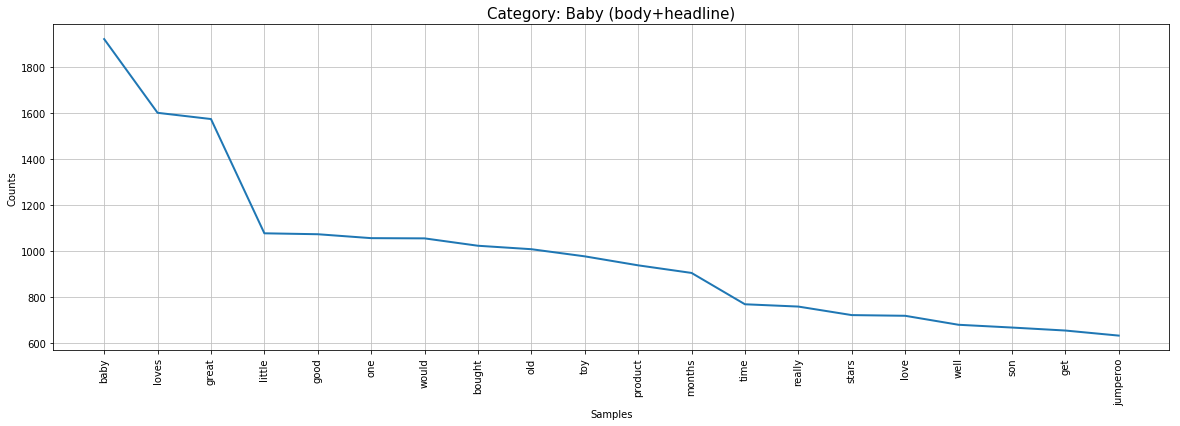

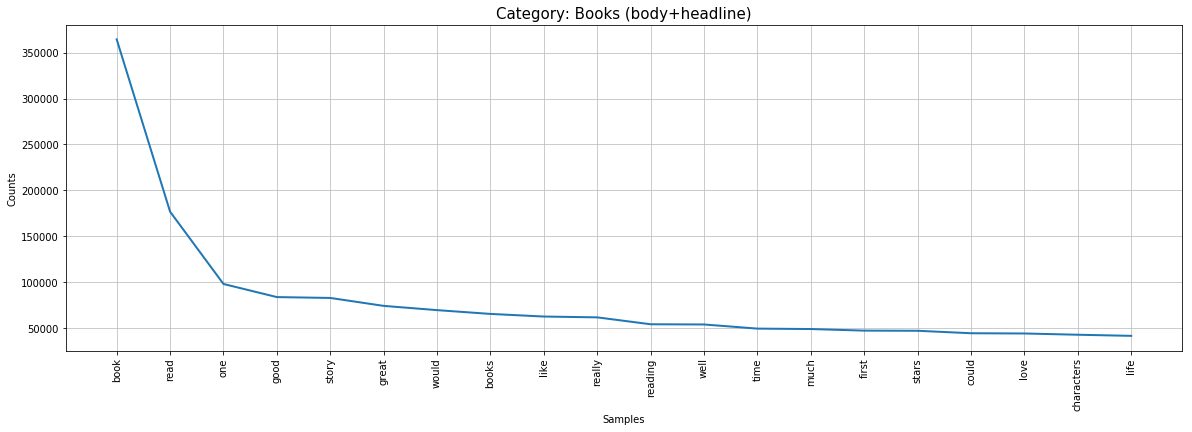

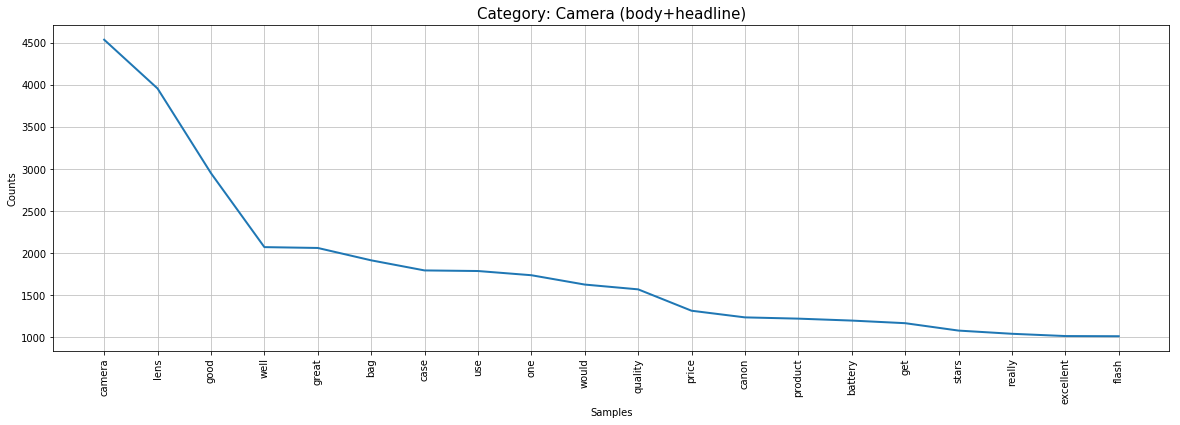

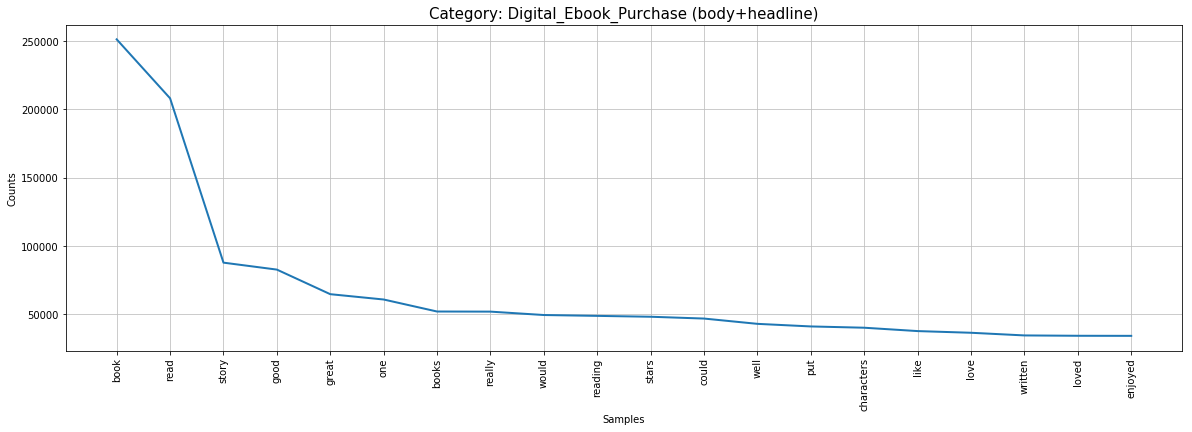

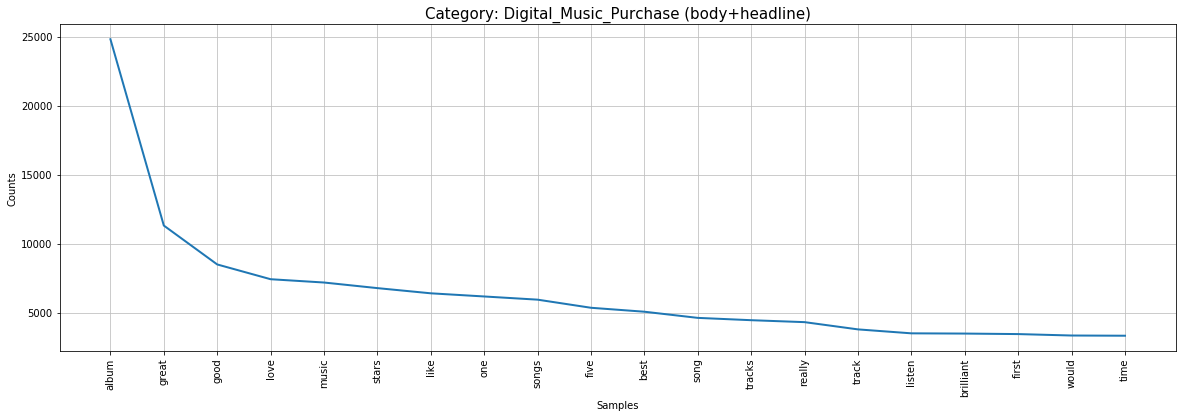

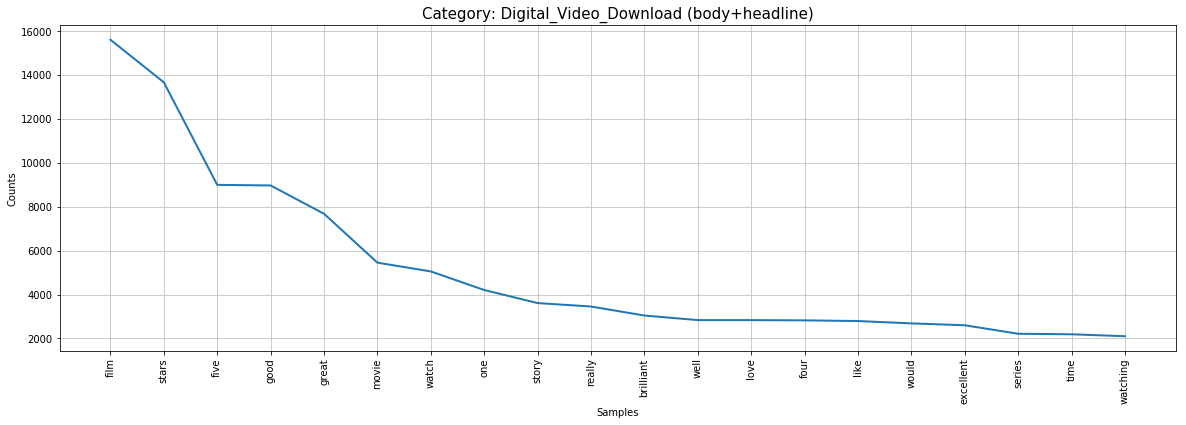

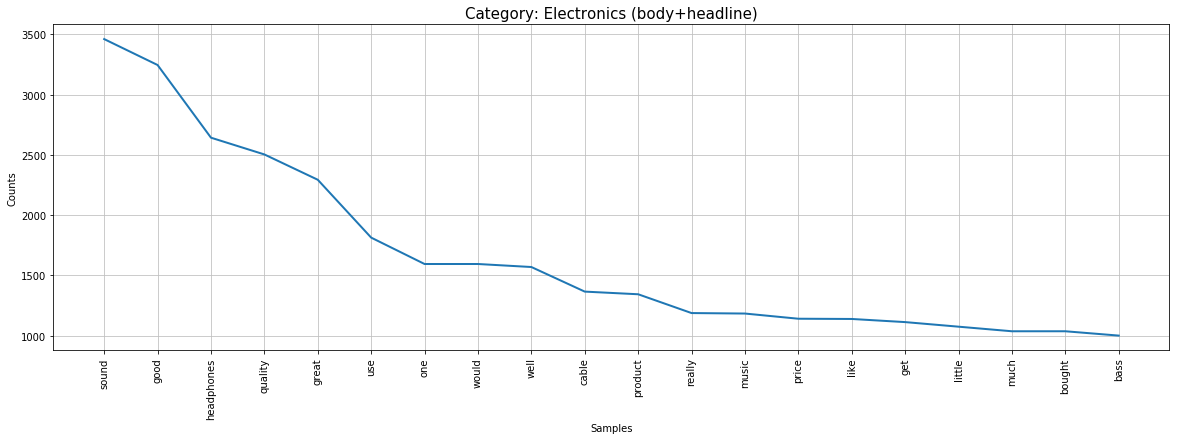

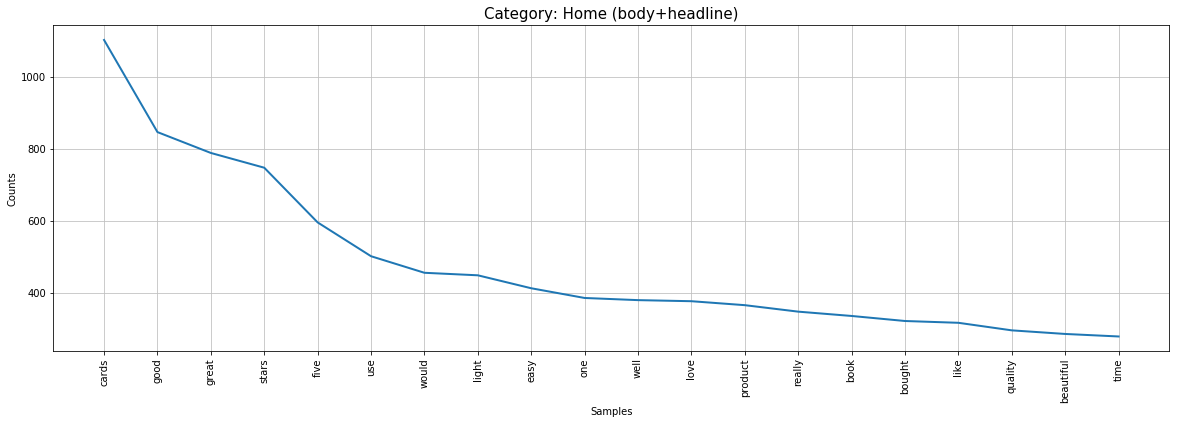

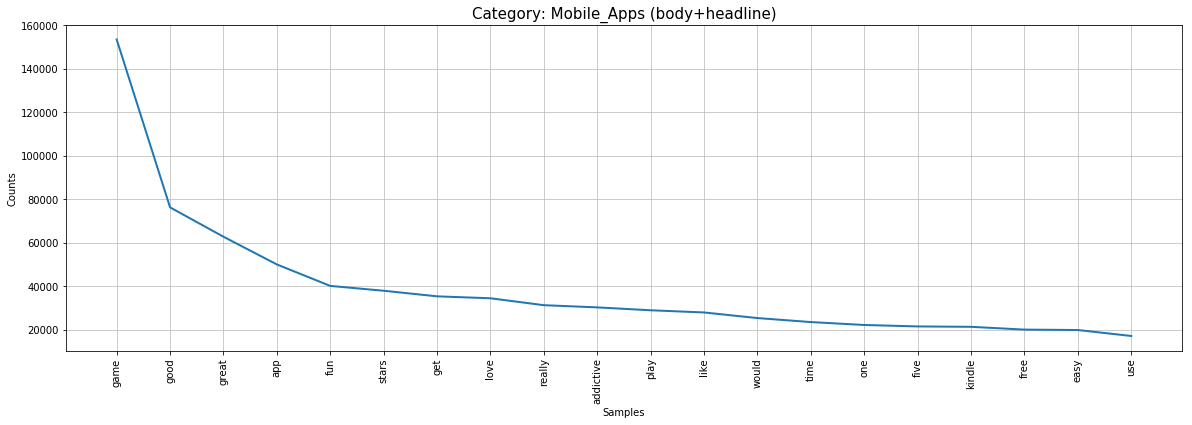

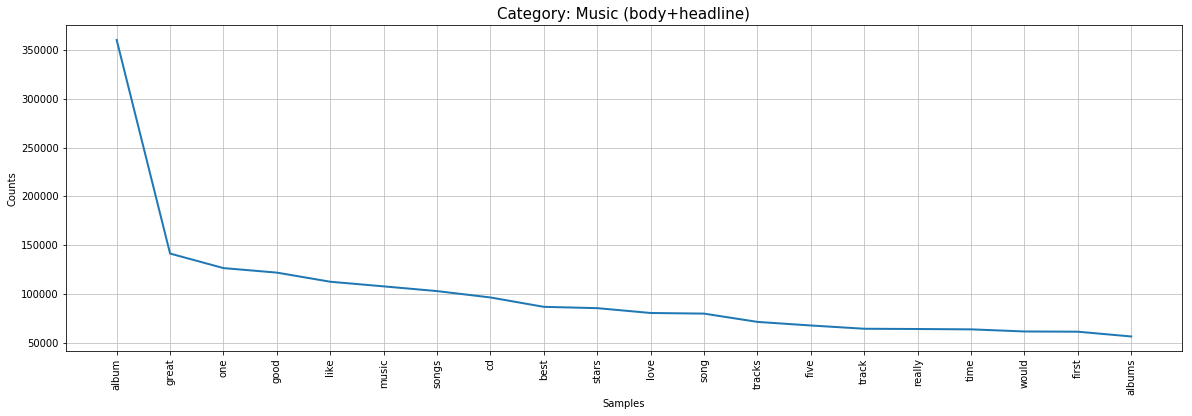

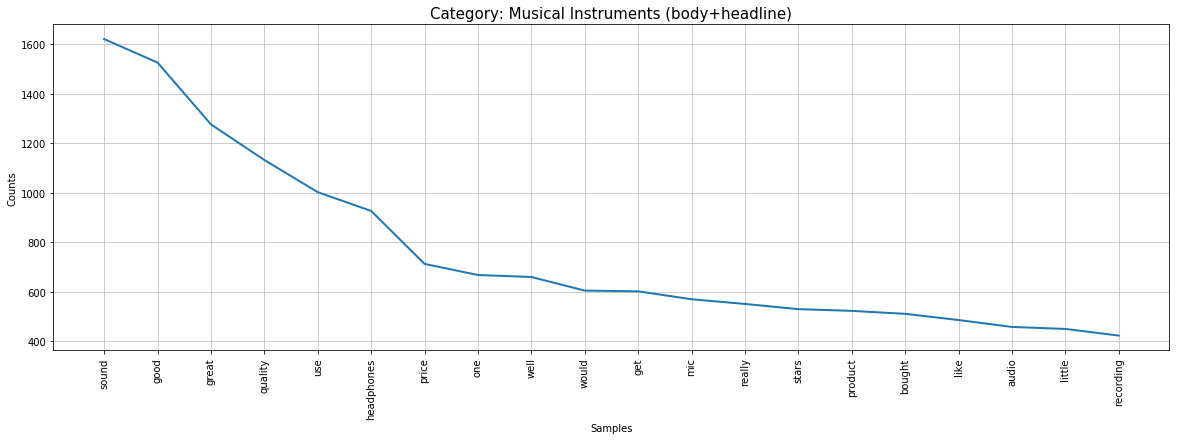

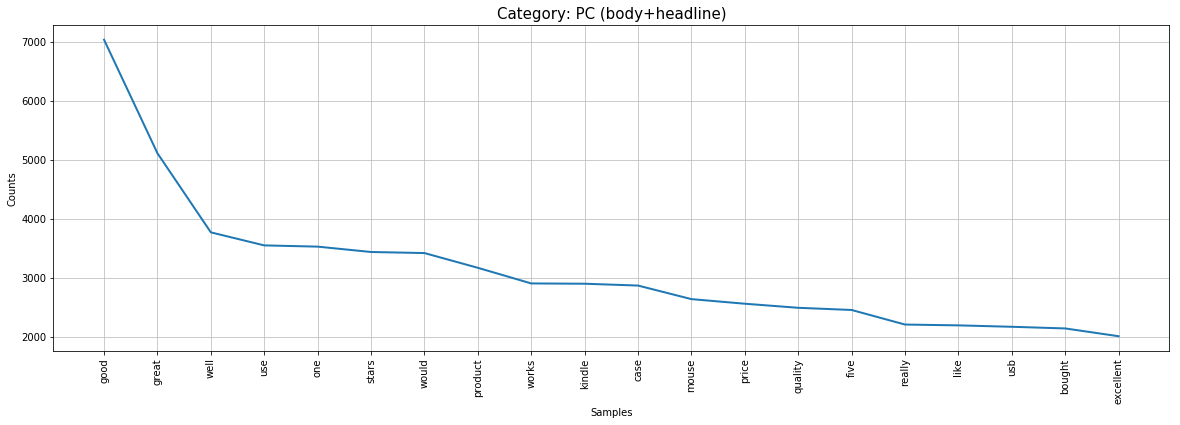

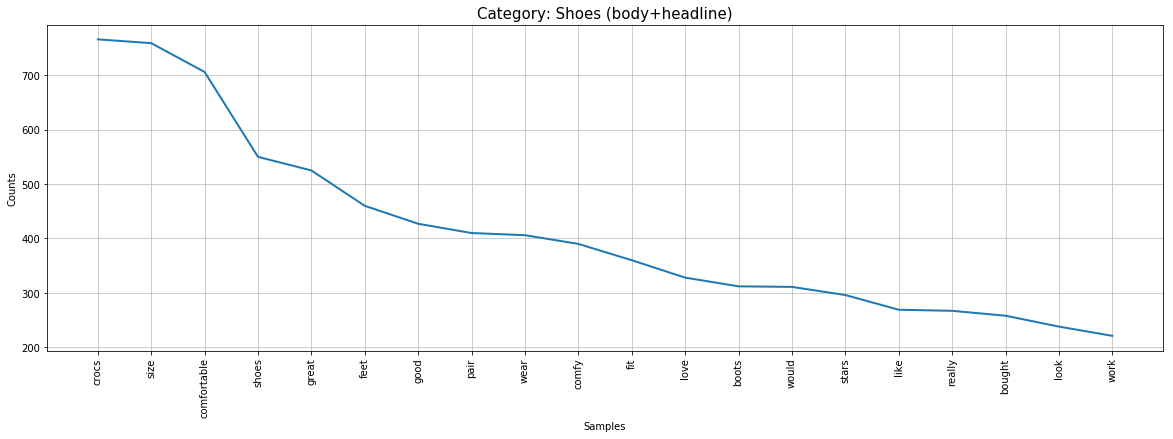

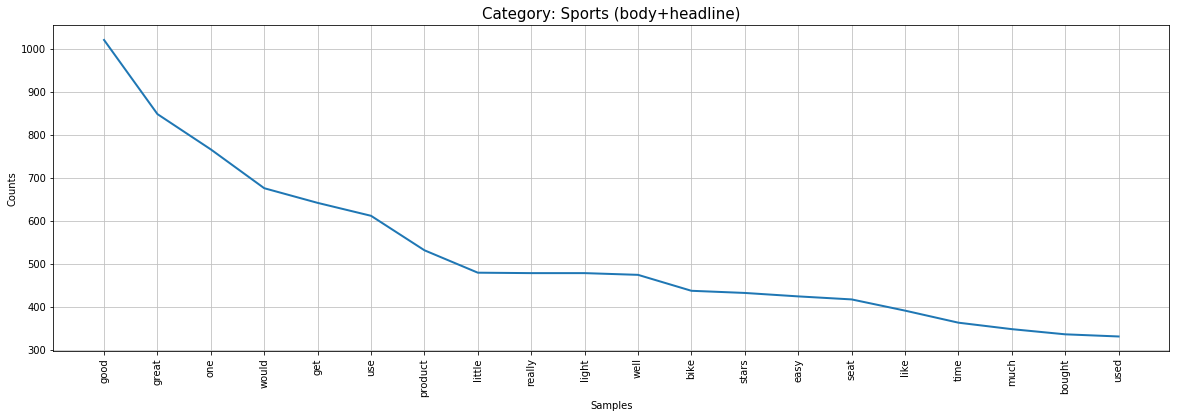

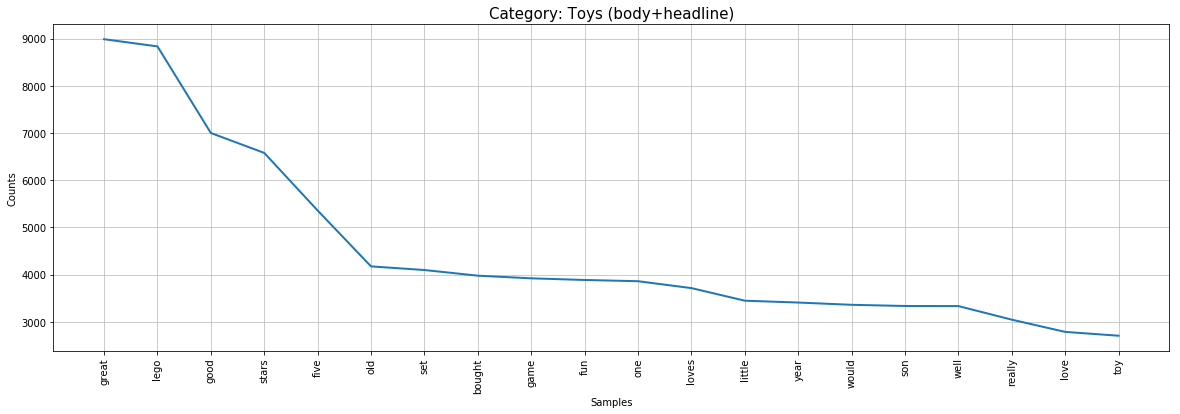

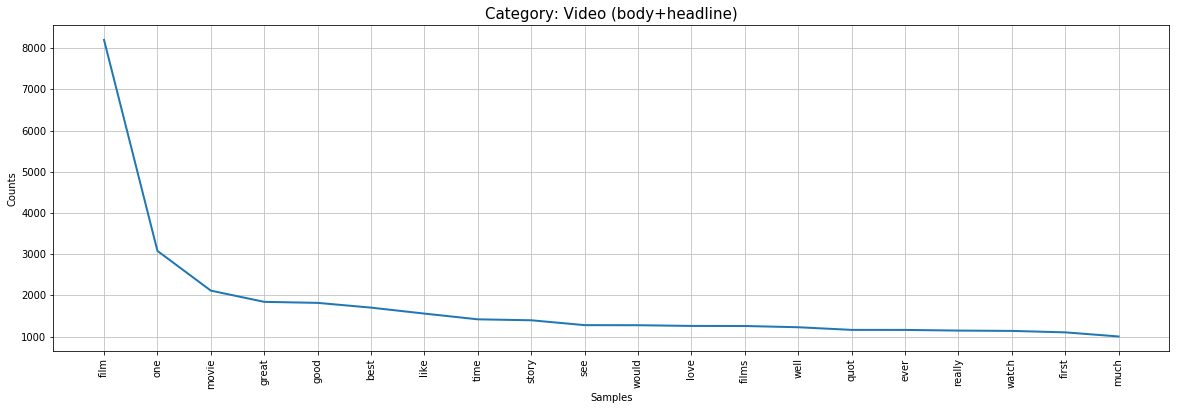

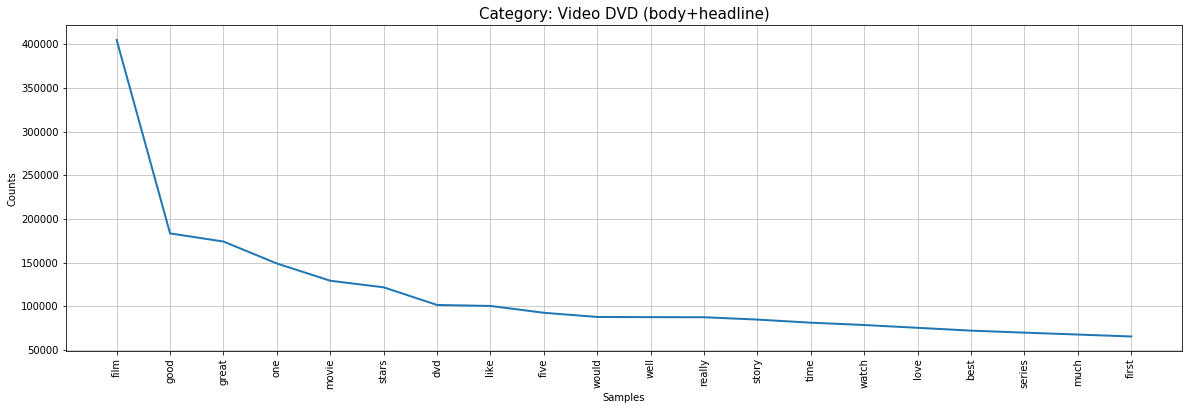

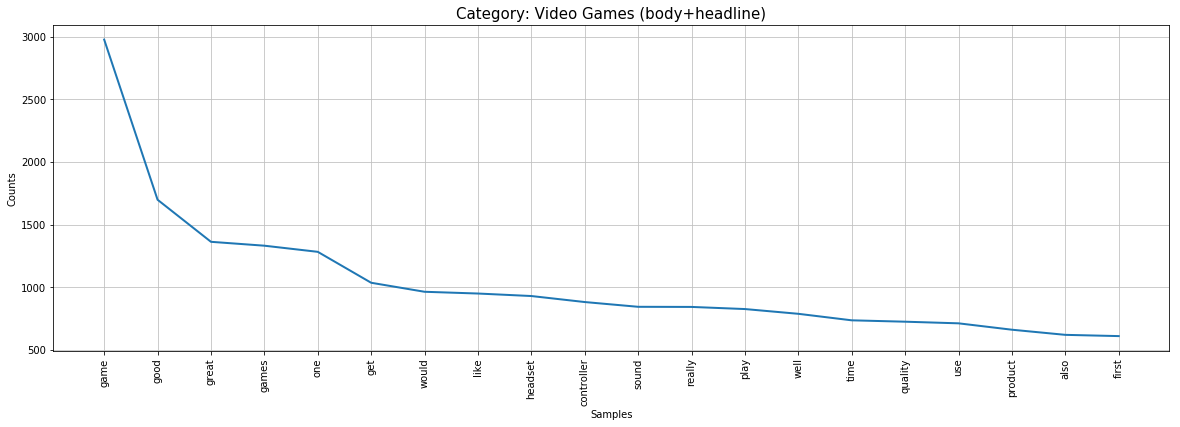

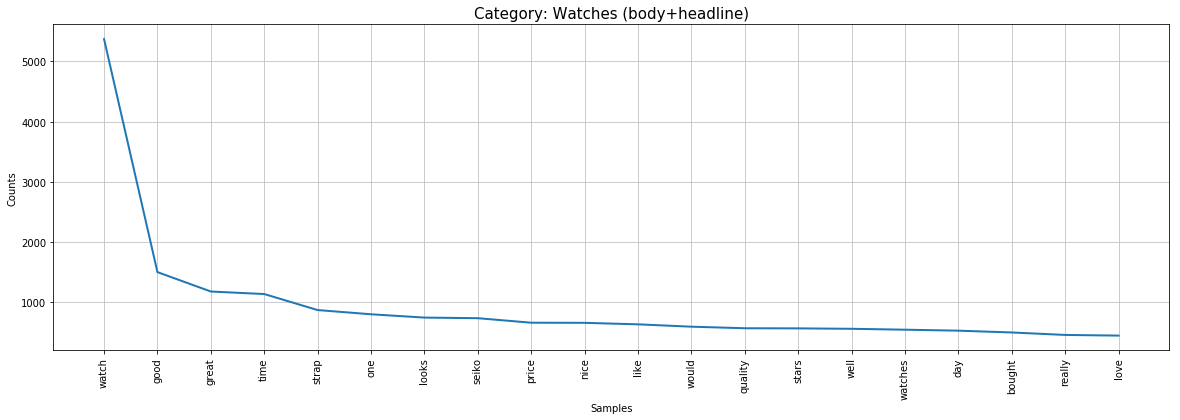

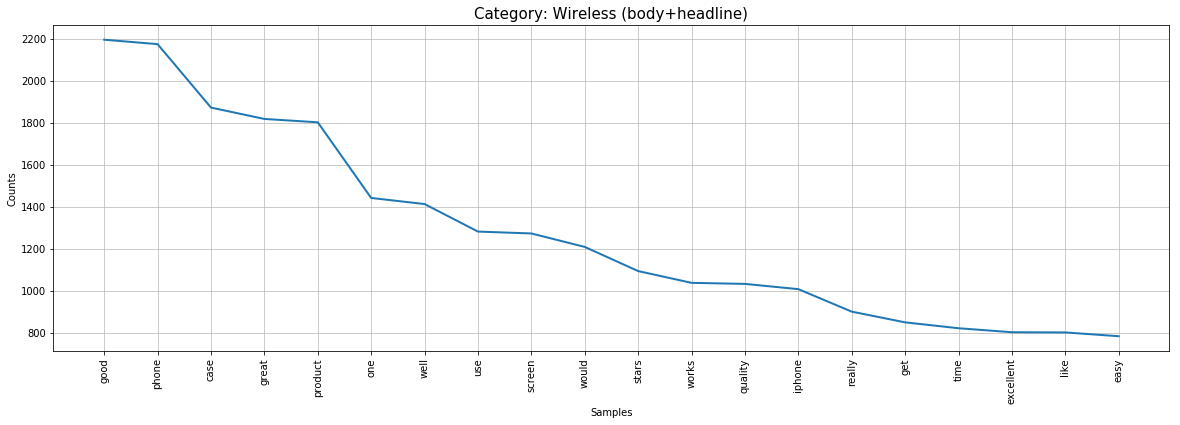

In [26]:
for c in categories:
    plotFreq(categories_reviews[c]+categories_reviews_headlines[c],"Category: %s (body+headline)" % c)
    plt.show()

>**Outcomes**:

> * As we can see, most of the graphs have an exponential trend. This means that people usually use are a really strict set of words to review products. 
> * It is visible that "good" and "great" are really common throughout all the graphs, as well as other adjectives like "well" and "nice". This is of course biased by the fact that a lot of reviews have 5 stars. On the other hand, it is possible to find a lot of words which are related to the respective category. For example: 
    * "film", "movie", "DVD" in "Video DVD".
    * "baby", "little", months" in "Baby".
    * "book", "read", "story" in "Books".
    * etc.

### Star rating' graphs of the most common 20 words (no stopwords)
>**Interests**: We are interested in the most common words for each set of reviews with a specific star rating. We expect to mostly find adjectives related to the star. For example, "worst" for 1 star, "excellent" for 5 stars etc. In addition, we want to see which if the frequncy distribution's trends follow the categories'ones.

>**Tool**: As before, the most important tool is represented by _nltk.FreqDist_ which performs the frequency distribution on a given text.

>**Application of the tool**: AS before, it will be printed out the frequency distribution of the 20 most common words for each star. Will be taking into account body and headline together.

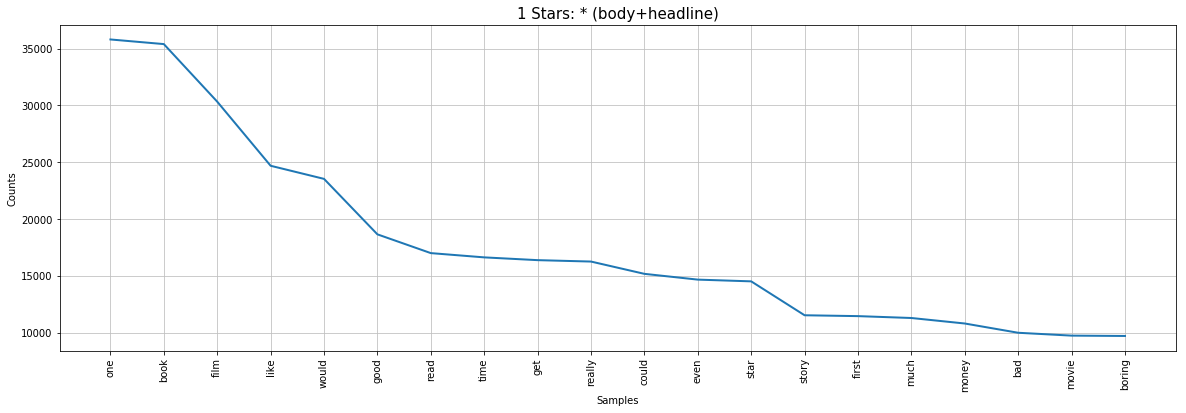

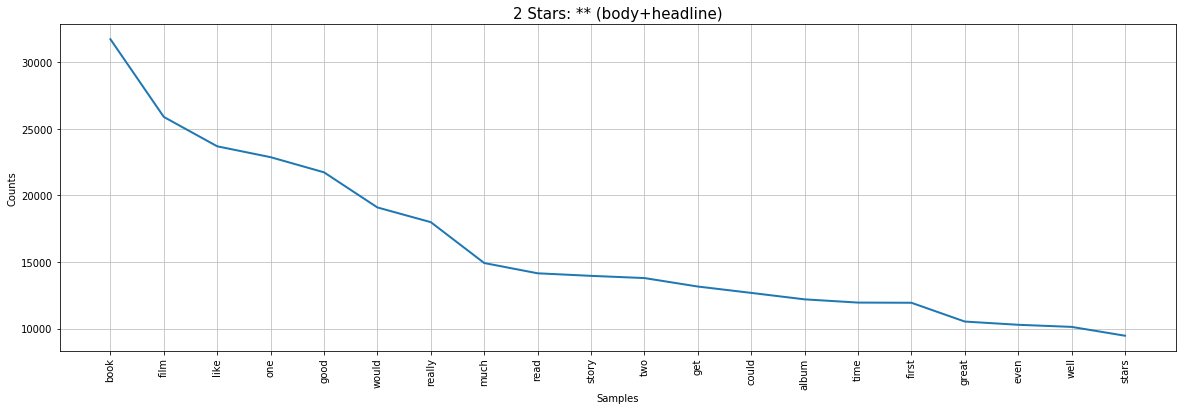

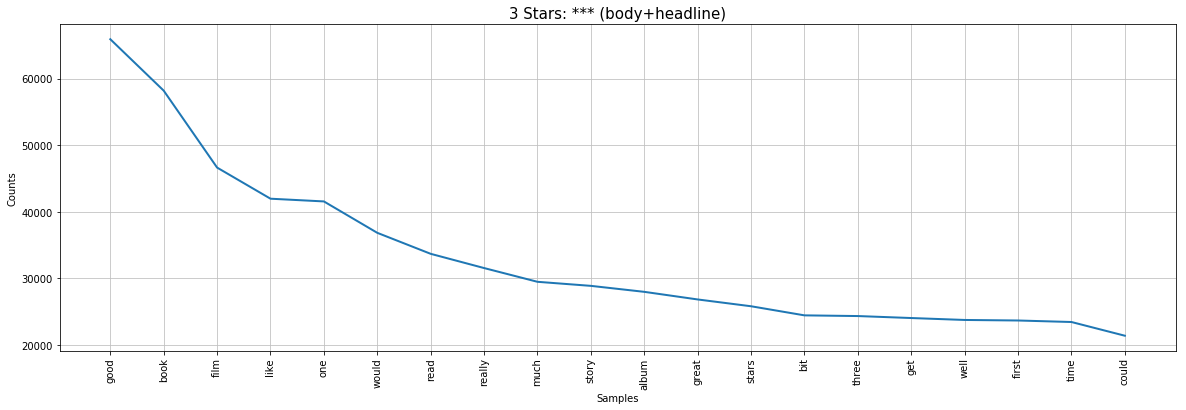

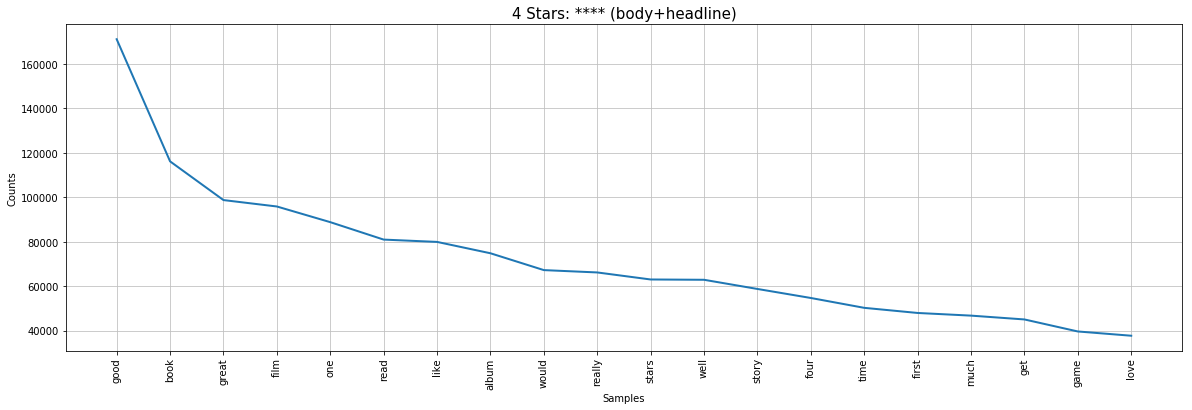

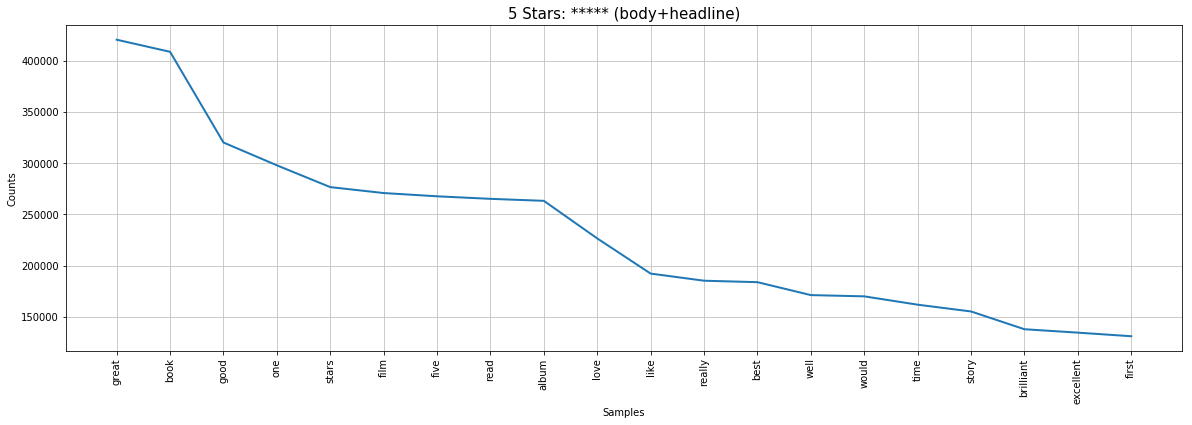

In [27]:
for i in range(1,6):
    plotFreq(stars_body[i]+stars_head[i],"%d Stars: %s (body+headline)" % (i,"*"*i))
    plt.show()

>** Outcomes **:
> * As before, as we could expect, the trends seem to be exponential. Therefore, we can came out with the same conclusions.
> * Regarding the specific words, we expected to have mostly adjectives rather than nouns. It is clear that the presence of a lot of reviews in book and video DVD category changes the actual results. Moreover, we forecasted to have adjectives which are actually relate with the star rating. It did not happen, in fact, "great", "good" are really common in all the star ratings.

## Lexical diversity or type-token ratio (TTR)
>**Interests**: We want to see the lexical richness of Amazon's reviews category. It is usually calculated comparing documents of similar lenghts. We hope that this suggestion is not really strict. We expect to find results which actually show that "technological" categories (Camera, Electronics, PC, Video Games, Wireless, ...) has generally a lower lexical diversity comparing to the "human" ones (Books, Video DVD, Digital EBook...). This is because we usually describe a book with a wider range of adjectives comparing to a router. In addition, we await to see a gap between body and headline because it is more common to find similar titles respect to similar bodies.

>**Tool**: Lexical Diversity refers to “the range of different words used in a text, with a greater range indicating a higher diversity“ (McCarthy and Jarvis 2010: 381).It is calculated as:
\begin{equation}
TTR(text) = \frac{|[w : w \in text]|}{|\{w : w \in text\}|}
\end{equation}
More TTR is near to one, more the text is "reach" of different words.

>**Application of the tool**: We will apply the tool twice for each category: one for the body and one for the headline. Then, we will plot a graph.

In [73]:
"""
\param text (list of strings)
\return lexical diversity
"""
def lexical_diversity(text):
    return len(text)/float(len(set(text)))

In [93]:
results = []
cats = []
types = []
for c in categories:
    results.append(lexical_diversity(categories_reviews[c]))
    results.append(lexical_diversity(categories_reviews_headlines[c]))
lexical = pd.DataFrame(
    {'Category': sorted(categories*2),
     'Type': ["Body","Headline"]*len(categories),
     'Lexical_Diversity': results
    }).sort_values(["Type","Lexical_Diversity"])

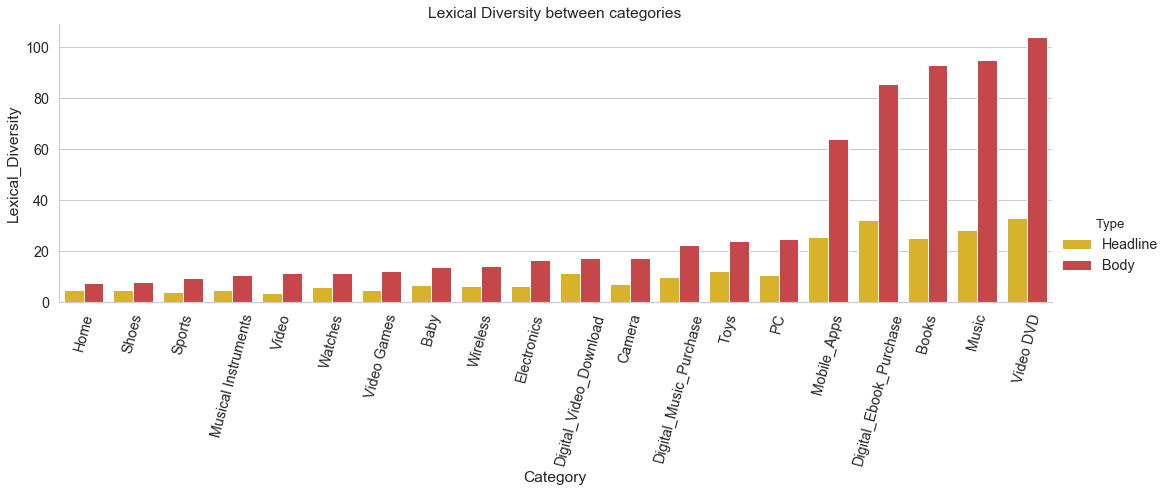

In [94]:
sns.set(font_scale=1.3,style="whitegrid")
sns.catplot(x="Category",y="Lexical_Diversity",data= lexical,hue="Type",kind="bar",aspect=3,hue_order=["Headline","Body"],palette=["#f4c20d","#db3236"])
plt.xticks(rotation=75)
plt.title("Lexical Diversity between categories")
plt.show()

> **Outcomes**: Comparing the results within the category context, it is not really useful. The problem, in this case, is that the number of reviews for each category biased the results. In fact, this graph is really similar to the one that appears in notebook Data-Processing. 

> ** Repetition of the test**: Since the problem is the difference between the number of words considered, we are going to filter the ones in excess. We will calculate which is the minimum number of words (for bodies and headlines) between all the categories. Therefore, we are going to repeat the test taking into consideration all and only the minimum number of words M calculated before. We are going to randomly choose M words from each category  using the function _random.sample_.

In [90]:
results = []
cats = []
types = []
maxBody = min([len(categories_reviews[c]) for c in categories])
maxHead = min([len(categories_reviews_headlines[c]) for c in categories])
for c in categories:
    results.append(lexical_diversity(random.sample(categories_reviews[c], maxBody)))
    results.append(lexical_diversity(random.sample(categories_reviews_headlines[c],maxHead)))
lexical = pd.DataFrame(
    {'Category': sorted(categories*2),
     'Type': ["Body","Headline"]*len(categories),
     'Lexical_Diversity': results
    }).sort_values(["Type","Lexical_Diversity"])

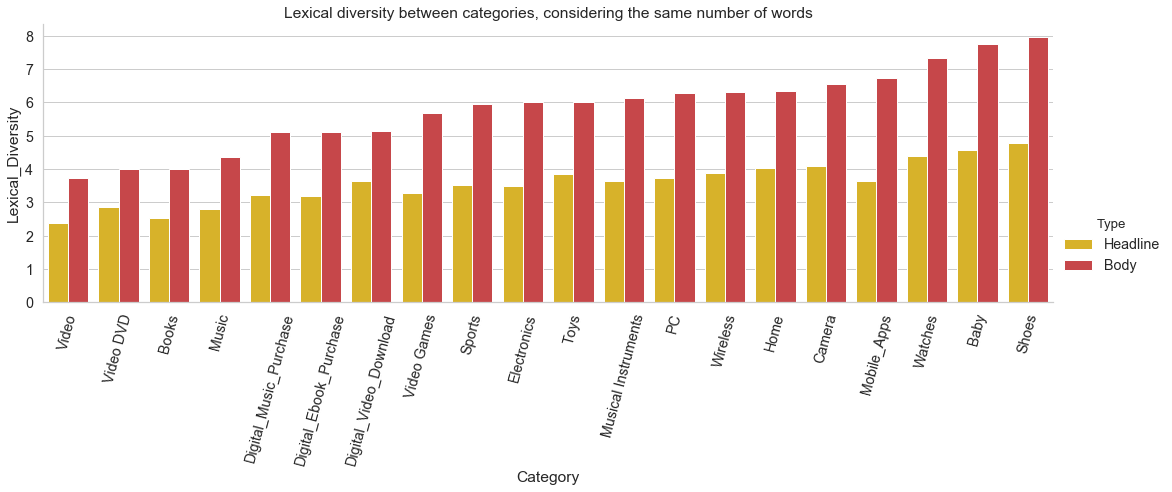

In [92]:
sns.set(font_scale=1.3,style="whitegrid")
sns.catplot(x="Category",y="Lexical_Diversity",data= lexical,hue="Type",kind="bar",aspect=3,hue_order=["Headline","Body"],palette=["#f4c20d","#db3236"])
plt.xticks(rotation=75)
plt.title("Lexical diversity between categories, considering the same number of words")
plt.show()

> **Outcomes**: 
* Now is actually possible to compare the differences. As we expect, "Video" and "Books" are really close to one. In contrast, the "Shoes" category seems poorest together with "Baby" and "Watches". 
* Regarding the difference between headline and body, we can see that there is a big gap. This means that reviewers usually use the same words to do the review's body, while they are more "creative" in the title.

## Tags: Adjectives, Nouns, Verbs and others
>**Interests**: We are interested in the distribution of the tags: "Adjectives, Nouns, Verbs". We would like to see if there are any differences between the categories. We expect to find more "adjectives" and "nouns" since we are analysing reviews.

>**Tool**: In order to achieve our goal, we are going to use _ntlk.pos_rag_ using the _tagset="universal"_. 

>**Application of the tool**: We will apply the tool for each category body and headline. Finally, we will plot two graphs showing the 4 distributions (in percentage) of adjectives, nouns, verbs, remaining ones.

### Data calculation

In [50]:
"""
\brief Given a list of strings, the function return the percentages of "Adjectives", "Nouns", "Verbs", "Other" which appear
in the list itself.
\param list of strings
\return list of float with 4 values described in brief
"""
def getStatsTags(listString):
    count = [0,0,0,0]
    for word,tag in nltk.pos_tag(listString,tagset="universal"):
        if(tag==u'ADJ'):
            count[0]+=1
        elif(tag==u'NOUN'):
            count[1]+=1
        elif(tag==u'VERB'):
            count[2]+=1
        else:
            count[3]+=1
    total = sum(count)
    return {u'ADJ':percent(count[0],total), u'NOUN':percent(count[1],total),u'VERB':percent(count[2],total),u'OTHER':percent(count[3],total)}

In [51]:
tags_head = dict()
for c in categories:
    tags_head[c] =  getStatsTags(categories_reviews_headlines[c])

In [52]:
tags_body = dict()
for c in categories:
    tags_body[c] =  getStatsTags(categories_reviews[c])

### Construction of the graph

In [53]:
data_head = [[],[],[],[]]
data_body = [[],[],[],[]]
for i,tag in enumerate([u'ADJ',u'NOUN',u'VERB',u'OTHER']):
    for c in categories:
        data_head[i].append(tags_head[c][tag])
        data_body[i].append(tags_body[c][tag])

In [54]:
def plotTags(title, data):
    plt.rcParams["figure.figsize"] = (20, 10)
    adj = plt.bar(categories, data[0],color="#0E7C7B")
    noun = plt.bar(categories, data[1],bottom=data[0],color="#17BEBB")
    verb = plt.bar(categories, data[2],bottom=[x + y for x, y in zip(data[0], data[1])],color="#D4F4DD")
    other = plt.bar(categories, data[3],bottom=[x + y + z for x, y, z in zip(data[0], data[1],data[2])],color="#D62246")
    plt.ylabel('Percentage')
    plt.xlabel('Categories')
    plt.title(title)
    plt.xticks(rotation=90)
    plt.legend((adj[0], noun[0], verb[0],other[0]), ('Adjectives', 'Nouns','Verbs','Others'),bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)
    plt.show()

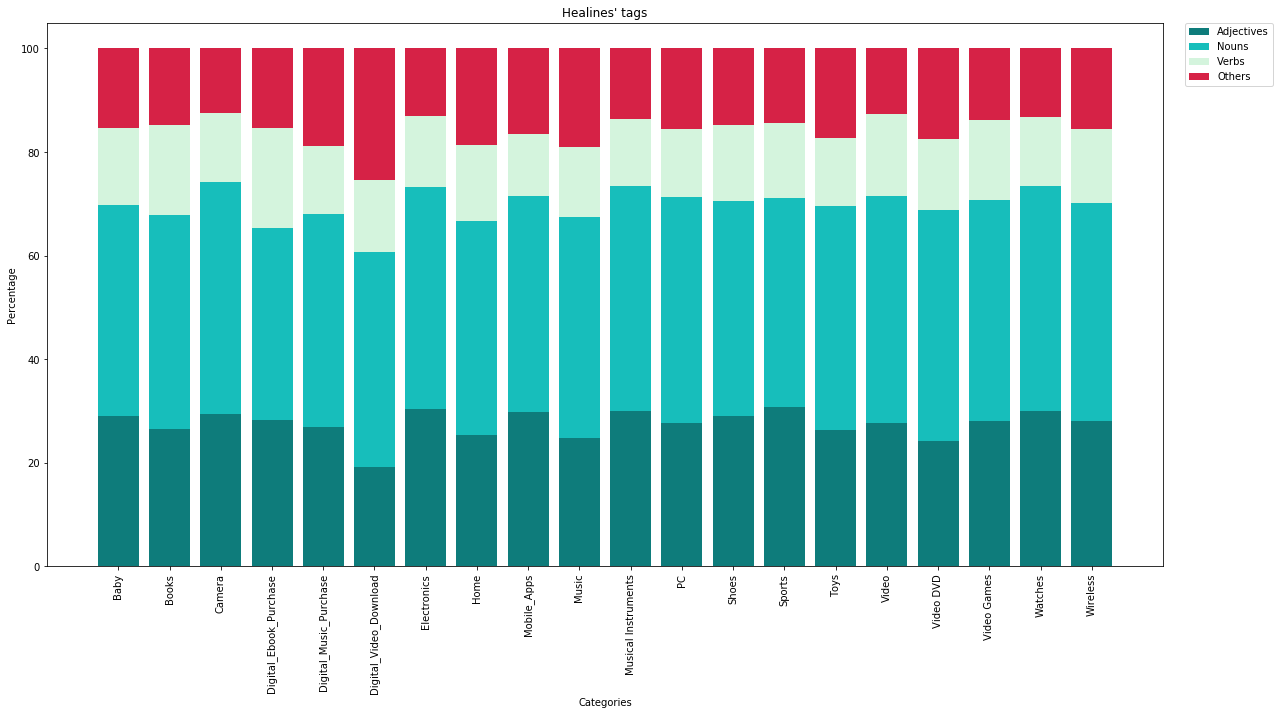

In [55]:
plotTags("Healines' tags",data_head)

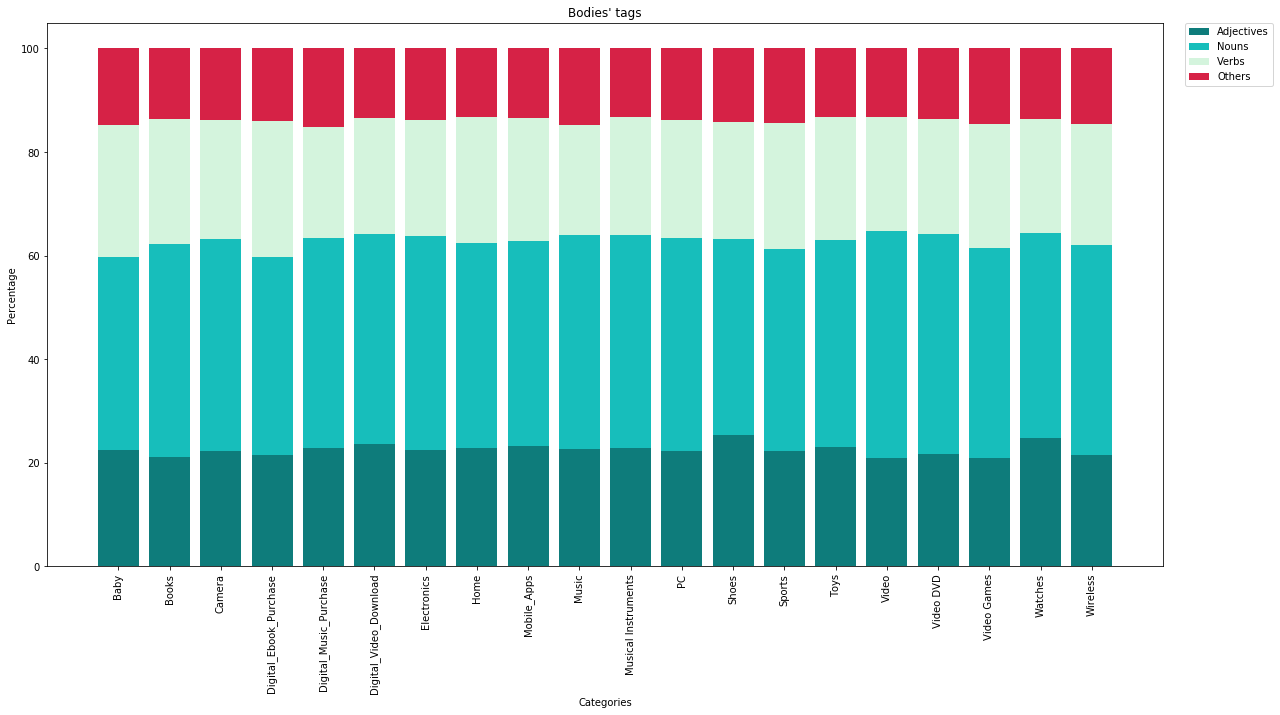

In [56]:
plotTags("Bodies' tags",data_body)

> **Outcomes**:
* The differences between categories are more evident in the headline's graph but still, they are really minor. 
* Comparing the two graphs, it can be seen that in the headlines is rarer to find verbs. As we forecasted, "Noun" and "adjectives" represents the most famous tags.

<a id="cell4"></a>

# 5) COLLOCATIONS
[**Table of contents**](#0)
>**Interests**: there are 2 goals. 1) Retrieve the collocations, bigram, and trigrams, for both texts with/without stopwords. And show the top4/top3 for bigrams/trigrams. 2) Actually, use these collocations to change the structures' text. Precisely, we want to keep the collocations as they are in the following chunks, in this way the analysis of the TF_IDF (which will be performed later) could be more interesting. In particular, in the word clouds, the 2/3 words (which form a collocation) will appear together and not in a random position (inside the picture).

>**Tool**: We will mainly use the functions provided by _nltk_ like _BigramCollocationFinder_ and _TrigramCollocationFinder_. 

>**Application of the tool**: We are going to find the top 30 bigrams/trigrams for each category with/without stopwords (will be filtered out the ones which are not repeated more than 3 times). We will save all the collocations found in the _set_: _collocations_. 

In [31]:
collocations = set()

### Bigrams (body+headline) with stopwords

In [32]:
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [43]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    res = []
    for index,row in df_rev[df_rev.product_category==c].iterrows():
        res += row.review_body+row.review_headline
    finder = BigramCollocationFinder.from_words(res)
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = [" ".join(r) for r in finder.nbest(bigram_measures.pmi, 30)]
    collocations.update(res)
    t.add_row([c,res[0],res[1],res[2],res[3]])
    del finder
t.align["Category"] = 'l'
print(t)

+--------------------------+----------------------+--------------------------+-----------------+-------------------+
| Category (body+headline) |         1st          |           2nd            |       3rd       |        4th        |
+--------------------------+----------------------+--------------------------+-----------------+-------------------+
|           Baby           |      cosi mura       |         lip balm         |    maxi cosi    |    silver cross   |
|          Books           |    baader meinhof    |       bani tihama        |  bhagavad gita  | crusonis annalium |
|          Camera          |     newton ellis     |        swan dice         |   casio exilim  |    iacute pode    |
|  Digital_Ebook_Purchase  |  blaenau ffestiniog  |    celaena sardothien    | charlize theron |     edema ruh     |
|  Digital_Music_Purchase  |   aretha franklin    |       dimmu borgir       |  helter skelter |    idina menzel   |
|  Digital_Video_Download  |     aldis hodge      |      cookie 

### Bigrams (body+headline) without stopwords

In [44]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd','4th'])
for c in categories:
    finder = BigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder.apply_freq_filter(3) ##ignoring all bigrams which occur less than three times in the corpus
    res = [" ".join(r) for r in finder.nbest(bigram_measures.pmi, 30)]
    collocations.update(res)
    t.add_row([c,res[0],res[1],res[2],res[3]])
    del finder
t.align["Category (body+headline)"] = 'l'
print(t)

+--------------------------+----------------------+--------------------------+--------------------+-------------------+
| Category (body+headline) |         1st          |           2nd            |        3rd         |        4th        |
+--------------------------+----------------------+--------------------------+--------------------+-------------------+
| Baby                     |      cosi mura       |         lip balm         |     maxi cosi      |    silver cross   |
| Books                    |    baader meinhof    |       bani tihama        |   bhagavad gita    | crusonis annalium |
| Camera                   |     newton ellis     |        swan dice         |    casio exilim    |    iacute pode    |
| Digital_Ebook_Purchase   |  blaenau ffestiniog  |    celaena sardothien    |  charlize theron   |     edema ruh     |
| Digital_Music_Purchase   |   aretha franklin    |       dimmu borgir       |   helter skelter   |    idina menzel   |
| Digital_Video_Download   |     aldis h

> **Outcome bigrams**: The differences between the two tables are really minor. It is interesting the fact that, most of them are actually brands and not meaningful words like "fingers crossed" in Shoes. Moreover, we can see funny results which we cannot really explain like:
* _hong kong_ in Wireless, probably it is used as a comparison to indicate really good devices.
* _rolls royce_ in PC, we would say the same as before.
* _hewlett packard_ Mobile and Apps, we would expect to find it in top4 of PC.

### Trigrams (body+headline) with stopwords

In [45]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [46]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    res = []
    for index,row in df_rev[df_rev.product_category==c].iterrows():
        res += row.review_body+row.review_headline
    finder = TrigramCollocationFinder.from_words(res)
    finder.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = [" ".join(r) for r in finder.nbest(trigram_measures.pmi, 30)]
    collocations.update(res)
    t.add_row([c,res[0],res[1],res[2]])
    del finder
t.align["Category"] = 'l'
print(t)

+--------------------------+------------------------------------+---------------------------------+--------------------------------+
| Category (body+headline) |                1st                 |               2nd               |              3rd               |
+--------------------------+------------------------------------+---------------------------------+--------------------------------+
|           Baby           |           maxi cosi mura           |       micro usb connector       |       maclaren techno xt       |
|          Books           |      pericla navarchi magonis      |    rebilii crusonis annalium    |       zaidi bani tihama        |
|          Camera          |           tr iacute pode           |           bla bla bla           |        lite tite swivel        |
|  Digital_Ebook_Purchase  |          schr ouml dinger          |          klu klux klan          |   soreness chafing tiredness   |
|  Digital_Music_Purchase  |  legal loopholes notwithstanding   |    

### Trigrams (body+headline) without stopwords

In [47]:
t = PT(['Category (body+headline)', '1st', '2nd', '3rd'])
for c in categories:
    finder = TrigramCollocationFinder.from_words(categories_reviews[c]+categories_reviews_headlines[c])
    finder.apply_freq_filter(3) ##ignoring all trigrams which occur less than three times in the corpus
    res = list(finder.nbest(trigram_measures.pmi, 30))
    res = [" ".join(r) for r in finder.nbest(trigram_measures.pmi, 30)]
    collocations.update(res)
    t.add_row([c,res[0],res[1],res[2]])
    del finder
t.align["Category"] = 'l'
print(t)

+--------------------------+----------------------------------+---------------------------------+------------------------------+
| Category (body+headline) |               1st                |               2nd               |             3rd              |
+--------------------------+----------------------------------+---------------------------------+------------------------------+
|           Baby           |          maxi cosi mura          |       micro usb connector       |      maclaren techno xt      |
|          Books           |     pericla navarchi magonis     |    rebilii crusonis annalium    |      zaidi bani tihama       |
|          Camera          |          tr iacute pode          |           bla bla bla           |       lite tite swivel       |
|  Digital_Ebook_Purchase  |      shailene woodley ansel      |   paracelsus agrippa albertus   |       schr ouml dinger       |
|  Digital_Music_Purchase  | legal loopholes notwithstanding  |      taxes legal loopholes      |

> **Outcome trigrams**: As before, the differences between the two tables are really minor and most of them are actually brands. Moreover, large part of them include the bigrams found before (as could be expected).  

>**Keep collocations**: we would keep the collocations as they are in the following analysis. Therefore, we are going to union (put together through a "\_") consecutive words which form a collocation. We are going to perform this transformation in each structure which contains text: dictionaries and data frames. To accomplish this task, we have created two functions _searchCollocationStructure_ and _changeInCollocations_ which will be applied to the structures mentioned before.

In [48]:
print("Taking the best 30 collocations for each category for each section (with/without stopwords), we have found %d distinct collocations" % len(collocations))

Taking the best 30 collocations for each category for each section (with/without stopwords), we have found 1486 distinct collocations


In [49]:
"""
The structure is designed in order to contain BIGRAM and TRIGRAMS.
Given a BIGRAM "A B" in the structure we will find: A->B->None
Given a TRIGRAM "A B C" in the structure we will find: A->B->C
If #collocations=["A B", "A B C", "D A"], the structure will be:{A:{B:{C,None}}, D:{A:{None}}}
Possible calls:
    structure[A] = {B:{C,None}}
    structure[A][B] = {C,None}
"""
def searchCollocationStructure(collocations):
    a = {}#Structure to boost the research of bigrams and trigrams
    for coll in collocations:
        split = coll.split(" ")
        a.setdefault(split[0],{}) 
        a[split[0]].setdefault(split[1],set())
        if(len(split)==3):
            a[split[0]][split[1]].add(split[2])
        else:
            a[split[0]][split[1]].add(None)
    return a

In [197]:
"""
\brief Given a list of words and the structure created using the function searchCollocationStructure; this function
returns the list of the elementes such that: if #listWords is ["A","B","C","D","C"] and "A B" is a collation, the list
returned is ["A_B","C","D","C"].
\param listWords : list of strings
\param structure : searchCollocationStructure()
"""
def changeInCollocations(listWords,structure):
    i = 0
    newList = []
    while(i<len(listWords)):
        find = False
        one = listWords[i]
        if(one in structure and i+1<len(listWords)):#the first word appears among the first words of the collocations
            two = listWords[i+1]
            if(two in structure[one]):#the second word appears among the second words of the collocations
                if(i+2<len(listWords) and listWords[i+2] in structure[one][two]):#the third word appears among the third words of the collocations
                    newList.append("_".join([one,two,listWords[i+2]]))#found a trigram
                    i+=3
                    find = True
                elif(None in structure[one][two]):
                    newList.append("_".join([one,two]))#found a bigram
                    i+=2
                    find = True    
        if(not find):
            newList.append(one)
            i+=1
    return newList

In [198]:
structure = searchCollocationStructure(collocations)

In [52]:
print("Example: ['technically', 'truer', 'ethos','house','cosi', 'mura'] -> ['%s'] " % "', '".join(changeInCollocations([u'technically', u'truer', u'ethos',u'house',u'cosi',u'mura'],structure)))

Example: ['technically', 'truer', 'ethos','house','cosi', 'mura'] -> ['technically_truer_ethos', 'house', 'cosi_mura'] 


### Processing of the text to keep the collocations

In [53]:
df_rev_stop["review_headline"] = df_rev_stop["review_headline"].apply(func = changeInCollocations,args=([structure]))
df_rev_stop["review_body"] = df_rev_stop["review_body"].apply(func = changeInCollocations,args=([structure]))
df_rev["review_body"] = df_rev["review_body"].apply(func = changeInCollocations,args=([structure]))
df_rev["review_headline"] = df_rev["review_headline"].apply(func = changeInCollocations,args=([structure]))

In [54]:
categories_reviews = {c:[] for c in categories}
categories_reviews_headlines = {c:[] for c in categories}

In [55]:
stars_body = {i:[] for i in range(1,6)}
stars_head = {i:[] for i in range(1,6)}

In [56]:
all_reviews_without_stopwords = []

In [57]:
for index,row in df_rev_stop.iterrows():
    categories_reviews[row.product_category]+= row.review_body
    categories_reviews_headlines[row.product_category]+= row.review_headline
    stars_body[row.star_rating]+=row.review_body
    stars_head[row.star_rating]+=row.review_headline

In [58]:
for i in range(1,6):
    all_reviews_without_stopwords+=stars_head[i]+stars_body[i]

<a id="tfidf"/>

# 6) COMMON WORDS vs TF_IDF
[**Table of contents**](#0)
> **Interests**: In this section we are going to analyze the differences between the use of the frequency and TF-IDF to retrieve the importance a word in a text.

>**Tool**: The TF-IDF (term frequency–inverse document frequency) is a numerical statistic which reflects how important a word is to a document. Its value increases proportionally with the number of times it appears in the document and it is offset by the number of pages that contain the word. The reason why it is offset is to balance the words that appear in many documents which, consequently, are not relevant. There are available many formulas, we have used the term frequency adjusted for document length:
\begin{equation}
\\TF-IDF(w, \ p) = \frac{f_{w,p}}{\sum_{w \in p} f_{w,p}} \log\left( \frac{N}{| p \in P:w \in p|}\right)\\
w = \text{considered word}\\
p = \text{page which contain } w\\
f_{w,p} = \text{frequency of the word } w \text{ in the page } p\\
N = \text{number of pages in the dataset}\\
| p \in P:w \in p| = \text{number of pages where w appears}\end{equation}

>**Application of the tool**: We are principally going to use the functions _tfIdf_ and _makeWordCloud_ which are described in the relative chunks.

### Functions

In [59]:
"""
\brief Given a vocabulary of frequency distributions, the functions return the same structure but, istead of the save frequency
it is saved the 
\param fdistList : vocabulary, key="title of the document"; value of the key k = nltk.FreqDist(k).
\return listTfIdf: vocabulary, key="title of the document"; value of the key k = vocabulary with keys = words and values = tf-idf.
"""
def tfIdf(fdistList):
    N_DOCUMENTS = len(fdistList)
    print("Total number of documents = %d" % N_DOCUMENTS)
    vocab = set()
    print("I'm creating the dictionary")
    for fdist in fdistList.values():
        vocab = vocab.union(set(fdist.keys()))#all words presents in all the documents
    idf = dict()
    print("I'm calculating the IDF")
    for word in vocab:
        count = sum([1 for fdist in fdistList.values() if(word in fdist)])
        idf[word] = math.log(N_DOCUMENTS/count)
    listTfIdf = dict()
    print("I'm calculating the tf-idf")
    i = 0
    for title, fdist in fdistList.items():
        listTfIdf[title] = dict()
        n_token_document = float(sum(fdist.values()))
        for word in fdist:
            listTfIdf[title][word] = fdist[word] * idf[word] /  n_token_document
        i+=1
    print("I have finished")
    return listTfIdf

In [228]:
"""
\brief Function to draw the wordcloud. After the call of this function, plt.show() is required.
\param dictWords :dictionary where keys=words, values=float or int
\param mask_path :string, path of the mask to be drawn. Must be saved in ./ImagesWordClouds/
\param background_color :string, color of the background of the image
\param max_words :int, number of maximum words to take into considearion
\param title :string, title of the picture
\param mux :int, In the case the values are float and less then 1, it is required to set mux at a reasonable value such that mux*value>1 for
each word.
\param subplots_params : tuple, in the case you want to use subplots
\param font :string, indicate the name of the font to be used. Must be saved in ./ImagesWordClouds/
"""
def make_word_cloud(dictWords,font, mask_path=None, background_color = "white", max_words = 2000, title = "", mux = 1, subplots_params = (1,1,1)):
    if(max_words>len(dictWords)):
        max_words = len(dictWords)
    topK = sorted(dictWords.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:max_words]
    text =[] 
    for word, value in topK:
        text+=[word]*int(round(value*mux))
    text = " ".join(text)
    if(mask_path!=None):
        # read the mask image
        mask = np.array(Image.open(mask_path))
        wc = WordCloud(background_color = background_color, max_words = max_words,  mask = mask, stopwords = None, collocations = False, max_font_size = 120, font_path="./ImagesWordClouds/"+font+".ttf")
        
    else:
        wc = WordCloud(background_color = background_color, max_words = max_words, stopwords = None, collocations = False, max_font_size = 120,font_path="./ImagesWordClouds/"+font+".ttf")
    # generate word cloud
    wc.generate(text)
    if(mask_path!=None):
        wc.recolor(color_func=ImageColorGenerator(mask))
    # store to file
    plt.rcParams["figure.figsize"] = (15, 10)
    plt.subplot(subplots_params[0], subplots_params[1], subplots_params[2])
    plt.title(title, fontsize = 15)
    plt.imshow(wc, interpolation = 'bilinear')
    plt.axis("off")

### Calculations of most common words 

>**Interests**: See a wordlcloud taking into account all the reviews (body+headline) using the most common word. The TF-IDF in this case wuold not have sense (because is like having 1 big document).

>**Tools**: The functions: _nltk.FreqDist_, _tfIdf_ and _makeWordCloud_.

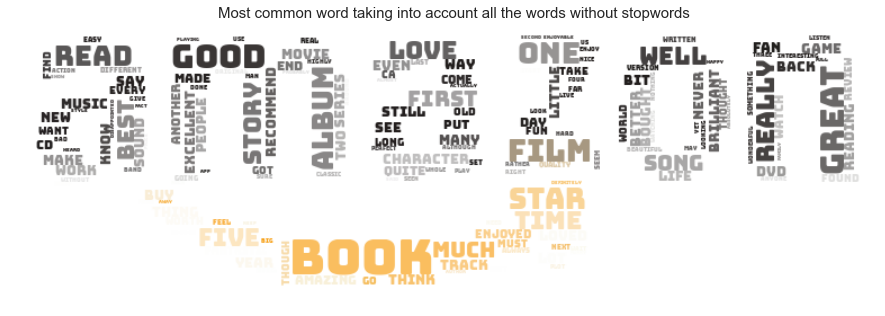

In [227]:
freq = nltk.FreqDist(all_reviews_without_stopwords)
make_word_cloud({v:k for v,k in freq.most_common(300)}, max_words = 300, title = "Most common word taking into account all the words without stopwords", mask_path = "ImagesWordClouds/amazon.jpg", font="Bungee-Regular")
plt.show()

> **Outcome**: As we could expect, most words are related to books and videos, which are the categories with highest number of reviews. Then, we can see a lot "good" adjectives. This is due to the fact of having a lot of good reviews.

In [274]:
heatDF = df_rev.groupby(["product_category","star_rating"]).count().reset_index()

In [275]:
matrix = np.zeros([len(categories),5])
cat_ind = {cat:i for i,cat in enumerate(categories)}
for index, row in heatDF.iterrows():
    matrix[cat_ind[row[0]],row[1]-1] = row[2]

62

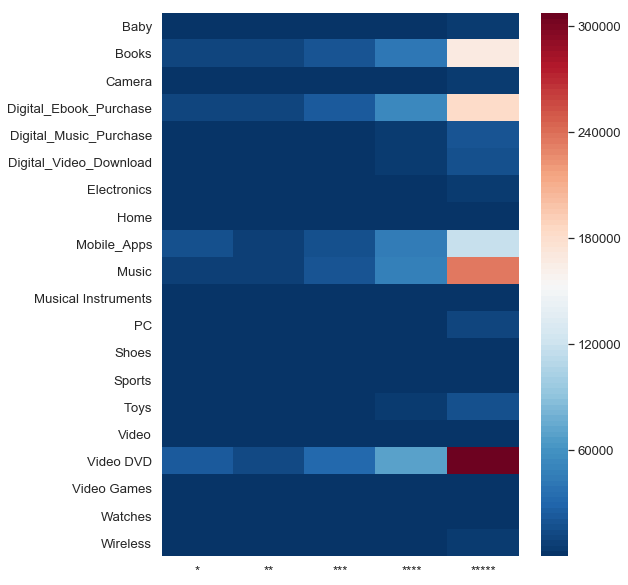

In [280]:
sns.set(font_scale=1.2,style="whitegrid",rc={'figure.figsize':(8,10)})
sns.heatmap(matrix, 
            xticklabels=['*'*i for i in range(1,6)], 
            yticklabels=categories,
           cmap=sns.color_palette("RdBu_r", 100),
           vmin=50)
plt.show()

### Calculation of most important words based on the TF-IDF for each category

In [ ]:
freq_dist_categories = dict()
for c in categories:
    freq_dist_categories[c] = nltk.FreqDist(categories_reviews[c]+categories_reviews_headlines[c])

In [ ]:
listTfIdf_categories = tfIdf(freq_dist_categories)

### Differences between Most common and TF-IDF words

Print the differences between them (body+headline)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud({v:k for v,k in freq_dist_categories[c].most_common(n)}, max_words = n, title = "Most common words in %s" % c, mask_path = "ImagesWordClouds/%s.jpg" % c,subplots_params=(1,2,1),font="Bungee-Regular")
    make_word_cloud(listTfIdf_categories[c], max_words = n, title = "TF-IDF words in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2), font="Pacifico-Regular")
    plt.show()

## TF-IDF body vs TF-IDF headline

In [ ]:
freq_dist_categories_bodies = dict()
for c in categories:
    freq_dist_categories_bodies[c] = nltk.FreqDist(categories_reviews[c])

In [ ]:
listTfIdf_bodies = tfIdf(freq_dist_categories_bodies)

In [ ]:
freq_dist_categories_headlines = dict()
for c in categories:
    freq_dist_categories_headlines[c] = nltk.FreqDist(categories_reviews_headlines[c])

In [ ]:
listTfIdf_headlines = tfIdf(freq_dist_categories_headlines)

In [ ]:
mux = len(all_reviews_without_stopwords) #This will multiply the tf-idf to make them bigger than 0., otherwise is not possible to create the text for the wordcloud.
n = 300
for c in categories:
    make_word_cloud(listTfIdf_bodies[c], max_words = n, title = "TF-IDF body in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,1),font="Bungee-Regular")
    make_word_cloud(listTfIdf_headlines[c], max_words = n, title = "TF-IDF headlline in %s" % c, mux = mux, mask_path = "ImagesWordClouds/%s.jpg" % c, subplots_params=(1,2,2), font="Pacifico-Regular")
    plt.show()

## Words based on the star_rating

We expect to find words which has a sentiment value based on the star rating. For example, for the reviews of 1 start, we expect to find: "bad, worst..". Moreover, we forcast to have better more interesting results using the most common words approach compare to the tf-idf.

### Differences between Most common and TF-IDF words

In [199]:
freq_dist_stars = dict()
for i in range(1,6):
    freq_dist_stars[i] = nltk.FreqDist(stars_body[i]+stars_head[i])

In [200]:
listTfIdf_stars = tfIdf(freq_dist_stars)

Total number of documents = 5
I'm creating the dictionary
I'm calculating the IDF
I'm calculating the tf-idf
I have finished


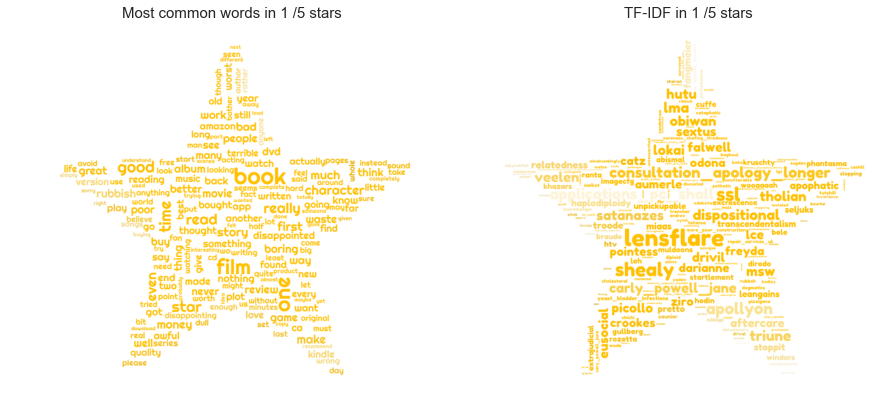

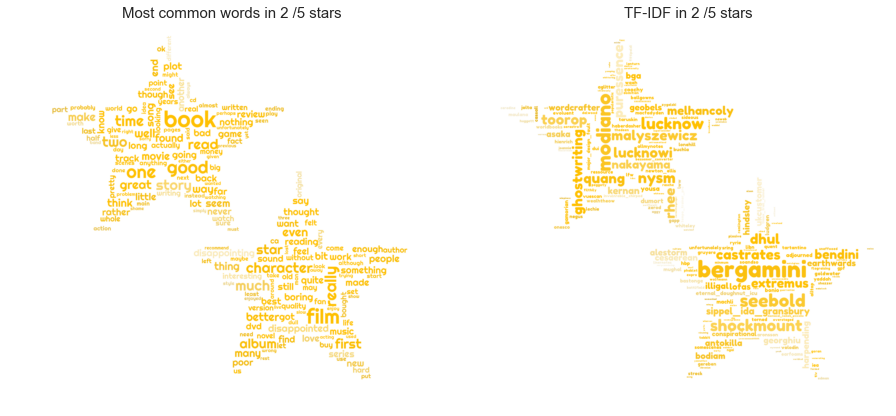

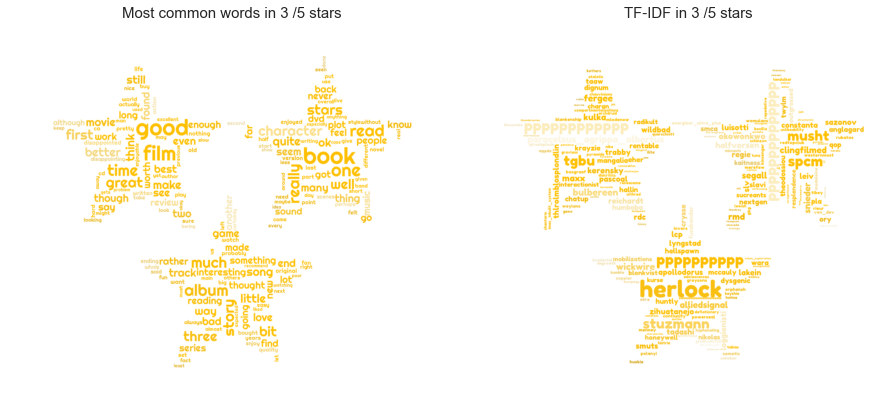

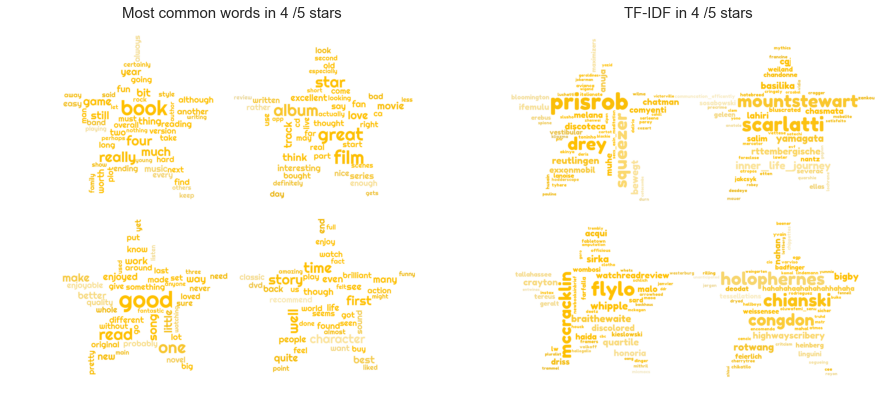

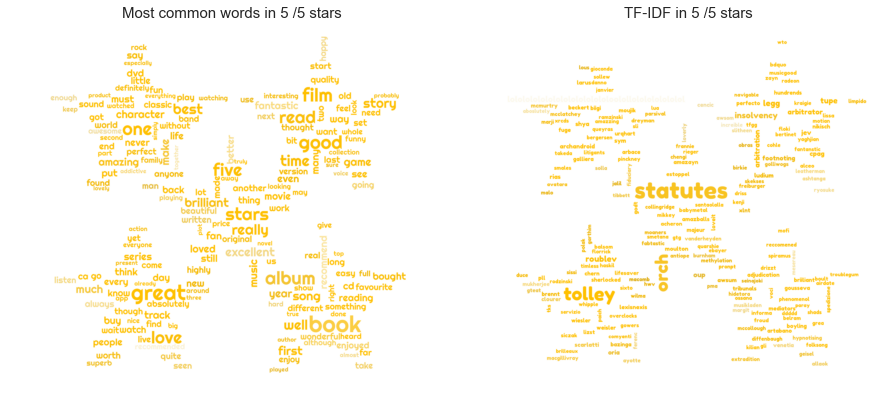

In [201]:
mux = len(all_reviews_without_stopwords)
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars[i], max_words = n, title = "TF-IDF in %d/5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,2), font="FredokaOne-Regular")
    make_word_cloud({v:k for v,k in freq_dist_stars[i].most_common(n)}, max_words = n, title = "Most common words in %d/5 stars" % i, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,1), font="Righteous-Regular")
    plt.show()

## TF-IDF body vs TF-IDF headline

In [207]:
freq_dist_stars_body = dict()
for i in range(1,6):
    freq_dist_stars_body[i] = nltk.FreqDist(stars_body[i])

In [208]:
listTfIdf_stars_body = tfIdf(freq_dist_stars_body)

Total number of documents = 5
I'm creating the dictionary
I'm calculating the IDF
I'm calculating the tf-idf
I have finished


In [209]:
freq_dist_stars_head = dict()
for i in range(1,6):
    freq_dist_stars_head[i] = nltk.FreqDist(stars_head[i])

In [210]:
listTfIdf_stars_head = tfIdf(freq_dist_stars_head)

Total number of documents = 5
I'm creating the dictionary
I'm calculating the IDF
I'm calculating the tf-idf
I have finished


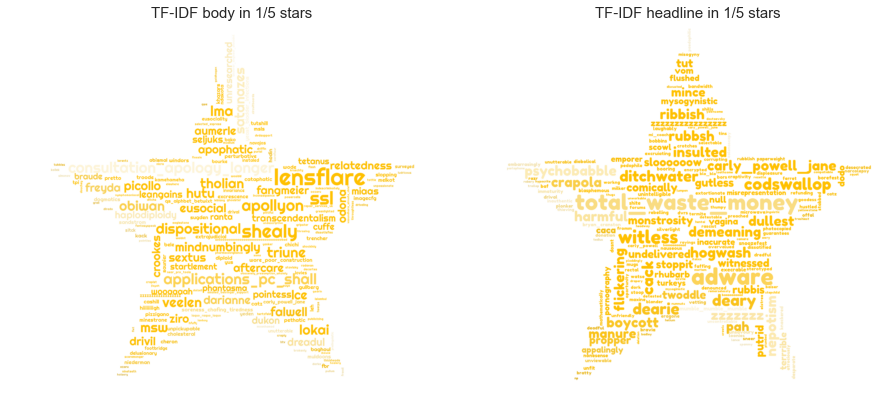

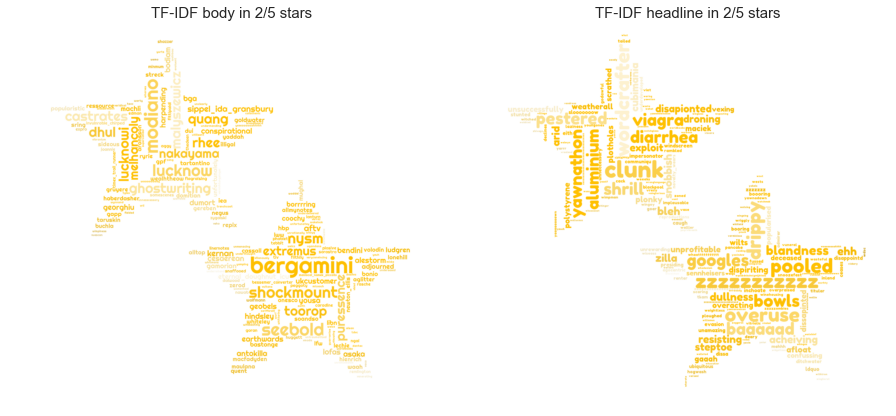

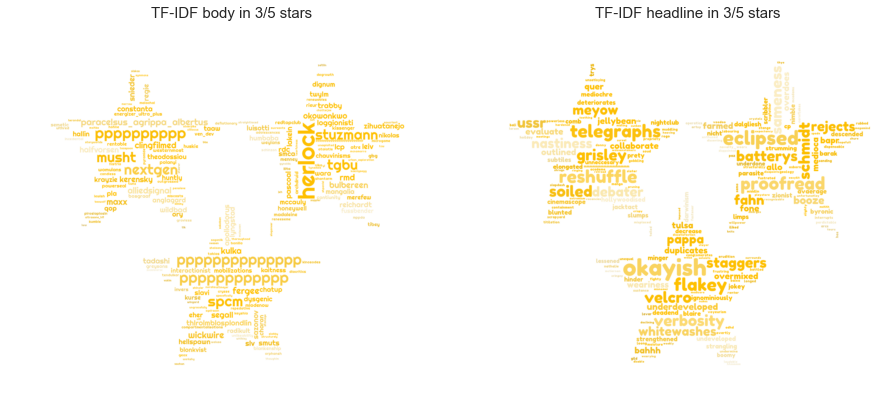

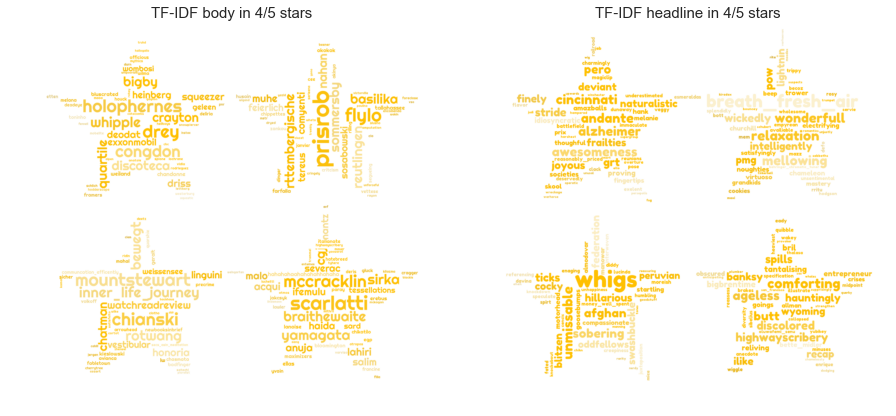

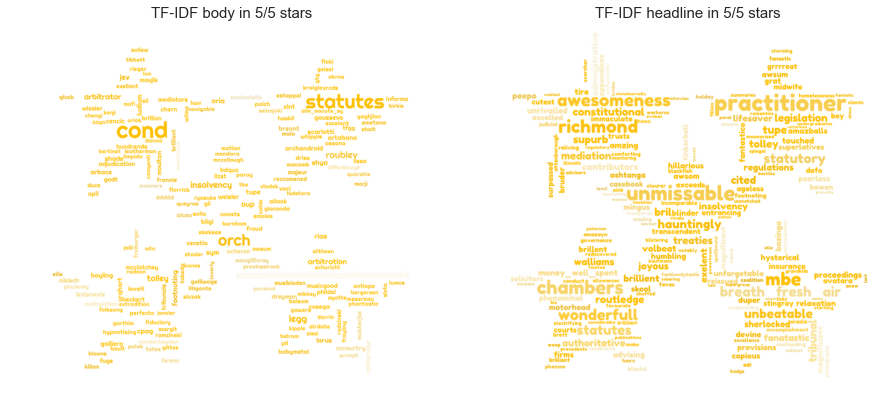

In [212]:
mux = len(all_reviews_without_stopwords)
n = 200
for i in range(1,6):
    make_word_cloud(listTfIdf_stars_head[i], max_words = n, title = "TF-IDF headline in %d/5 stars" % i, mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,2),font="FredokaOne-Regular")
    make_word_cloud(listTfIdf_stars_body[i], max_words = n, title = "TF-IDF body in %d/5 stars" % i,mux = mux, mask_path = "ImagesWordClouds/%dstars.jpg" % i,subplots_params=(1,2,1),font="Righteous-Regular")
    plt.show()

### Conclusions

It seems it is far better to look at the headline to catch the "sentiment" of the reviews.

# Similarities between categories

In [110]:
def sim(tfIdfCat1, tfIdfCat2):
    
    words1 = set(tfIdfCat1.keys())
    words2 = set(tfIdfCat2.keys())
    
    intersection = words1.intersection(words2)
    in1NotIn2 = words1.difference(words2)
    in2NotIn1 = words2.difference(words1)
    
    array1, array2 = [], []
    for word in intersection:
        array1.append(tfIdfCat1[word])
        array2.append(tfIdfCat2[word])
    for word in in1NotIn2:
        array1.append(tfIdfCat1[word])
        array2.append(0)
    for word in in2NotIn1:
        array1.append(0)
        array2.append(tfIdfCat2[word])
    
    return 1 - spatial.distance.cosine(array1,array2)

In [111]:
matrix = np.zeros([len(categories), len(categories)])
for i,ci in enumerate(categories):
    for j,cj in enumerate(categories):
        matrix[i,j] = sim(listTfIdf_categories[ci],listTfIdf_categories[cj])

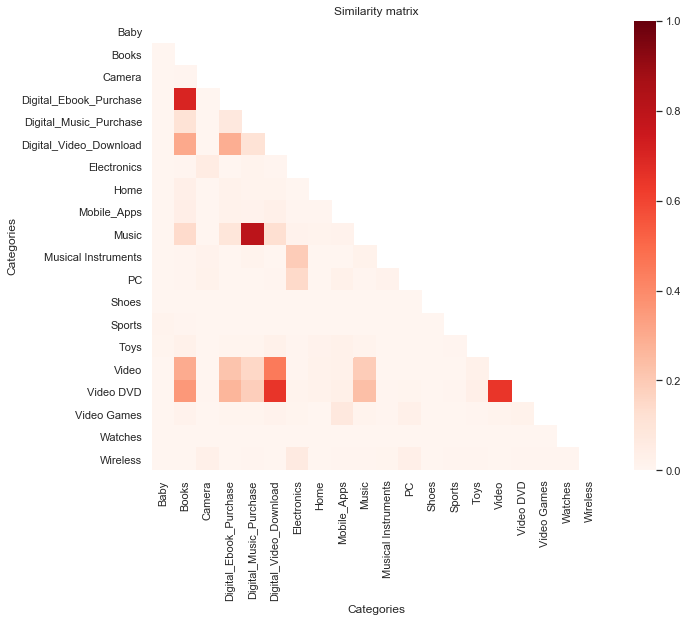

In [112]:
plt.rcParams.update({'font.size': 15})
sns.set(rc={'figure.figsize':(11.7,8.27)},style="white")
mask = np.zeros_like(matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(matrix, fmt=".4f",vmin=0, vmax=1,xticklabels=categories,yticklabels=categories,mask=mask,square=True,cmap="Reds")
plt.title("Similarity matrix")
plt.xlabel("Categories")
plt.ylabel("Categories")
plt.show()

# Sentiment analysis

## Pre proccessing

### Word List

SentiWords is a high coverage resource containing roughly 155.000 English words associated with a sentiment score included between -1 and 1. Words in this resource are in the form lemma#PoS and are aligned with WordNet lists (that include adjectives, nouns, verbs and adverbs). Scores are learned from SentiWordNet and represent state-of-the-art computation of words' prior polarities (i.e. polarity for non-disambiguated words) using SWN.  SentiWords was built using the method described in Guerini et al. (2013) and the dataset presented in Warriner et al. (2013). For a thorugh description see Gatti et al. (2015).

Page link: https://hlt-nlp.fbk.eu/technologies/sentiwords

References: http://hltdistributor.fbk.eu/license.php?licenseId=f99f59c080464addad699f91bd8c190e

In [113]:
sentiment = dict()
sentiment_collocations = dict()
with codecs.open("Data/sentimentalWords.txt",encoding="utf-8") as f:
    rows = f.readlines()
    for row in rows:
        hash = row.find('#')
        if('_' not in row[:hash]):
            sentiment[row[:hash]] = float(re.findall(r"[-+]?\d*\.\d+|\d+",row[hash+2:])[0])
        else:
            sentiment_collocations[row[:hash]] = float(re.findall(r"[-+]?\d*\.\d+|\d+",row[hash+2:])[0])

In [114]:
t = PT(['Rank', 'Best Word', 'Best value', 'Worst word', 'Worst value'])
best = (sorted(sentiment.iteritems(), key = lambda (k, v): (v, k), reverse = True)[:10])
worst = (sorted(sentiment.iteritems(), key = lambda (k, v): (v, k))[:10])
i=0
for wb,ww in zip(best,worst):
    t.add_row([i+1,wb[0],wb[1],ww[0],ww[1]])
    i+=1
print(t)

+------+-----------+------------+------------+-------------+
| Rank | Best Word | Best value | Worst word | Worst value |
+------+-----------+------------+------------+-------------+
|  1   |  vacation |  0.89489   |  leukemia  |   -0.91897  |
|  2   |    joy    |  0.85897   |   rapist   |   -0.91761  |
|  3   | happiness |  0.85671   |  torture   |   -0.87315  |
|  4   |  magical  |  0.84836   |  mourning  |   -0.86926  |
|  5   |   happy   |  0.84599   | gonorrhea  |   -0.86349  |
|  6   |   joyful  |  0.84043   |   abuse    |   -0.86257  |
|  7   |    hug    |  0.83735   |    rape    |   -0.86119  |
|  8   | enjoyment |  0.83668   |   herpes   |   -0.86051  |
|  9   |    fun    |  0.83395   | unsanitary |   -0.85026  |
|  10  |  lovable  |   0.8244   |   murder   |   -0.84831  |
+------+-----------+------------+------------+-------------+


### Choose if use the dataframe with/without stopwords

In [115]:
print("There are %d/%d stopwords in the sentiment list " % (sum([1 for w in STOPWORDS if w in sentiment]),len(STOPWORDS)))

There are 78/180 stopwords in the sentiment list 


Given those results we are going to use the dataframe which contains the stopwords.

### Collocations filtering

In [116]:
colloc = {v.replace(" ","_") for v in collocations}
sentiment_collocations = {k:sentiment_collocations[k] for k in colloc if k in sentiment_collocations}

These are the actual collocations which can be found in our sentiment list.

In [117]:
print("Collocations: %s" % ", ".join(sentiment_collocations))

Collocations: bobby_fischer, stainless_steel, san_francisco, et_al, cookie_cutter, spinal_tap, terra_firma, sun_visor, alarm_clock, grand_theft, reverse_gear, mont_blanc, lucrezia_borgia, chromatic_aberration, caveat_emptor, deja_vu, beats_per_minute, magnifying_glass, jules_verne, sherlock_holmes, mobile_phone, vacuum_cleaner, kahlil_gibran, nail_varnish, ku_klux_klan, james_bond, lip_balm, tour_de_force, bessemer_converter, nusa_tenggara, vice_versa, poison_ivy, methylated_spirit, robert_de_niro, carpal_tunnel, skating_rink, taj_mahal, hong_kong, mary_jane, jelly_bean, south_africa, los_angeles, stocking_filler, full_metal_jacket, andrew_lloyd_webber, puerto_rico, washing_machine, stiff_upper_lip, frances_hodgson_burnett


We add the collocations value to the dictionary which will be actually used for the calculation of the sentimental value.

In [118]:
for k,v in sentiment_collocations.items():
    sentiment[k] = v

Since only a fraction of the "original" collocations are part of the list we will split the ones which are not part of it. This is because maybe the separeted words have a value.

In [119]:
def splitIfNotInSentiment(listWords,listSentimentColl):
    ret = []
    for l in listWords:
        if("_" in l and l in listSentimentColl):
            ret.append(l)
        else:
            ret+=l.split("_")
    return ret

In [120]:
df_rev["review_body"] = df_rev["review_body"].apply(func = splitIfNotInSentiment,args=([sentiment_collocations.keys()]))
df_rev["review_headline"] = df_rev["review_headline"].apply(func = splitIfNotInSentiment,args=([sentiment_collocations.keys()]))

### Sentimental function

In [151]:
#Given a list of words, the function returns the average sentiment. 
#If the word (or its stem) is not present in the list, it is not taken into account.
#If #tokenListString has no words present in the list, the function return np.nan
#\param tokenListString = string of words
#\param wordListCSV = csv file created above
#\return h_avg(T) if tokenListString have at least one word in #wordListCSV, False otherwise
def sentimentCalculator(listWord, sentiment, stemmer):
    return np.nanmean([sentiment.get(word,sentiment.get(stemmer.stem(word),np.nan)) for word in listWord])

### Creation of the "sentimental columns"

In [152]:
processing = False
try:
    df_rev = pd.read_pickle("%sReviewsForSentiment.pkl" % PATH_DATA)
except IOError as I:
    processing = True

In [153]:
if(processing):
    df_rev["sentiment_body"] = np.zeros(len(df_rev), dtype=float)
    df_rev["sentiment_headline"] = np.zeros(len(df_rev), dtype=float)
    porter = nltk.PorterStemmer()

In [154]:
if(processing):
    for index,listWords in zip(df_rev.index,df_rev.review_body):
        df_rev.at[index,"sentiment_body"] = sentimentCalculator(listWords, sentiment, porter)

In [155]:
if(processing):
    for index,listWords in zip(df_rev.index,df_rev.review_headline):
        df_rev.at[index,"sentiment_headline"] = sentimentCalculator(listWords, sentiment, porter)

In [156]:
if(processing):
    print("Will be remove %d/%d rows because they contain nan values after the calculation of the sentimental value" % (df_rev.isnull().values.sum(),len(df_rev)))
    df_rev = df_rev.dropna()
    df_rev.to_pickle("%sReviewsForSentiment.pkl" % PATH_DATA) #save the file

Will be remove 37918/1683454 rows because they contain nan values after the calculation of the sentimental value


In [157]:
df_rev.head()

customer_id  product_id  \
review_id                           
0               10349  B00MWK7BWG   
1               10629  B006CHML4I   
2               12136  B00IIFCJX0   
3               12268  B000W7JWUA   
4               12677  B005JTAP4S   

                                               product_title  \
review_id                                                      
0                                 My Favourite Faded Fantasy   
1          Seiko 5 Men's Automatic Watch with Black Dial ...   
2                                            Dexter Season 8   
3          The Settlers of Catan Board Game - discontinue...   
4                        Peter: A Darkened Fairytale (Vol 1)   

                 product_category  star_rating              review_headline  \
review_id                                                                     
0                           Music            5                [five, stars]   
1                         Watches            4  [great, watch, from, casio]   
2          Digital_Video_Download            5                  [fantastic]   
3                            Toys            5                [five, stars]   
4          Digital_Ebook_Purchase            5        [a, twist, on, tales]   

                                                 review_body review_date  \
review_id                                                                  
0                                   [the, best, album, ever]  2014-12-29   
1          [what, a, great, watch, both, watches, and, st...  2013-10-24   
2          [love, watching, all, the, episodes, of, dexte...  2014-05-09   
3                                          [excellent, game]  2014-09-19   
4          [this, cute, quick, read, is, very, different,...  2013-09-18   

           sentiment_body  sentiment_headline  
review_id                                      
0                0.040693            0.299330  
1                0.090670            0.059845  
2                0.049179            0.819230  
3                0.340635            0.299330  
4                0.098754            0.097995

In [158]:
aggregation_body = df_rev[['product_category','star_rating','sentiment_body']].groupby(['product_category','star_rating']).agg({'sentiment_body': ['mean', 'std','count']}).reset_index()
aggregation_body.columns = aggregation_body.columns.droplevel(0)
aggregation_body.columns = ["product_category", "star_rating", "mean", "std", "count"]

In [159]:
aggregation_body.head()

product_category  star_rating      mean       std  count
0             Baby            1  0.035073  0.096186    128
1             Baby            2  0.060278  0.045528    127
2             Baby            3  0.080637  0.058516    231
3             Baby            4  0.114425  0.080625    557
4             Baby            5  0.151145  0.108783   3161

In [160]:
aggregation_head = df_rev[['product_category','star_rating','sentiment_headline']].groupby(['product_category','star_rating']).agg({'sentiment_headline': ['mean', 'std','count']}).reset_index()
aggregation_head.columns = aggregation_head.columns.droplevel(0)
aggregation_head.columns = ["product_category", "star_rating", "mean", "std", "count"]

In [161]:
aggregation_head.head()

product_category  star_rating      mean       std  count
0             Baby            1  0.005701  0.248128    128
1             Baby            2  0.020637  0.223431    127
2             Baby            3  0.137115  0.196609    231
3             Baby            4  0.234453  0.220338    557
4             Baby            5  0.287943  0.214383   3161

## Analysis

### Categories vs Star rating

#### Line charts

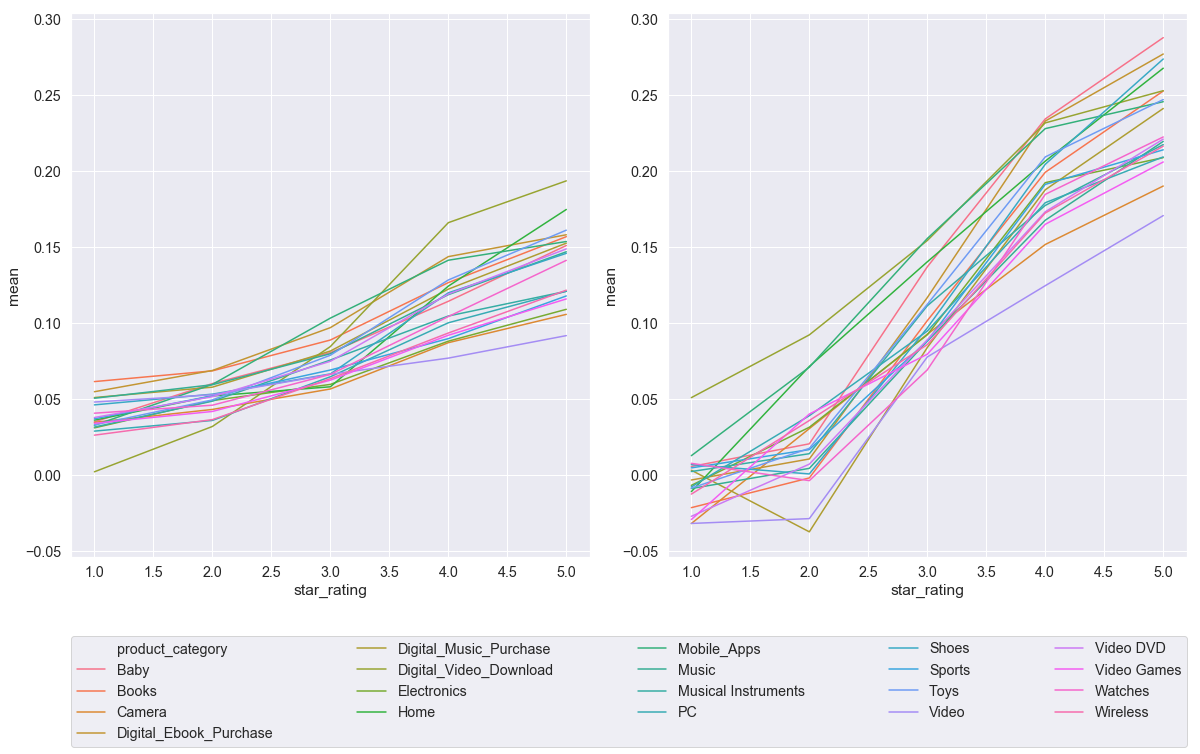

In [162]:
sns.set(rc={'figure.figsize':(20,10)},font_scale=1.3)
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=+0.15)
sns.lineplot(x="star_rating", 
             y="mean",
             hue="product_category", 
             markers=True, 
             dashes=True,
             ci="std",
             data=aggregation_body,
             ax=ax)
sns.lineplot(x="star_rating", 
             y="mean",
             hue="product_category", 
             markers=True, 
             dashes=True,
             ci="std",
             data=aggregation_head,
             ax=ax2)
ax.get_legend().remove()
ax.set(ylim=ax2.get_ylim())
plt.legend(bbox_to_anchor=(-1.15, -.35, 2.15, -.102), loc=3,ncol=5, mode="expand", borderaxespad=0.)
plt.show()

#### Heatmap charts

In [163]:
matrix = np.zeros([len(categories), 5])
cat_ind = {cat:i for i,cat in enumerate(categories)}
for index, row in aggregation_body.iterrows():
    matrix[cat_ind[row[0]],row[1]-1] = row[2]

In [164]:
matrix_head = np.zeros([len(categories), 5])
cat_ind = {cat:i for i,cat in enumerate(categories)}
for index, row in aggregation_head.iterrows():
    matrix_head[cat_ind[row[0]],row[1]-1] = row[2]

In [165]:
min_mean = min(aggregation_body["mean"].min(),aggregation_head["mean"].min())
max_mean = min(aggregation_body["mean"].max(),aggregation_head["mean"].max())

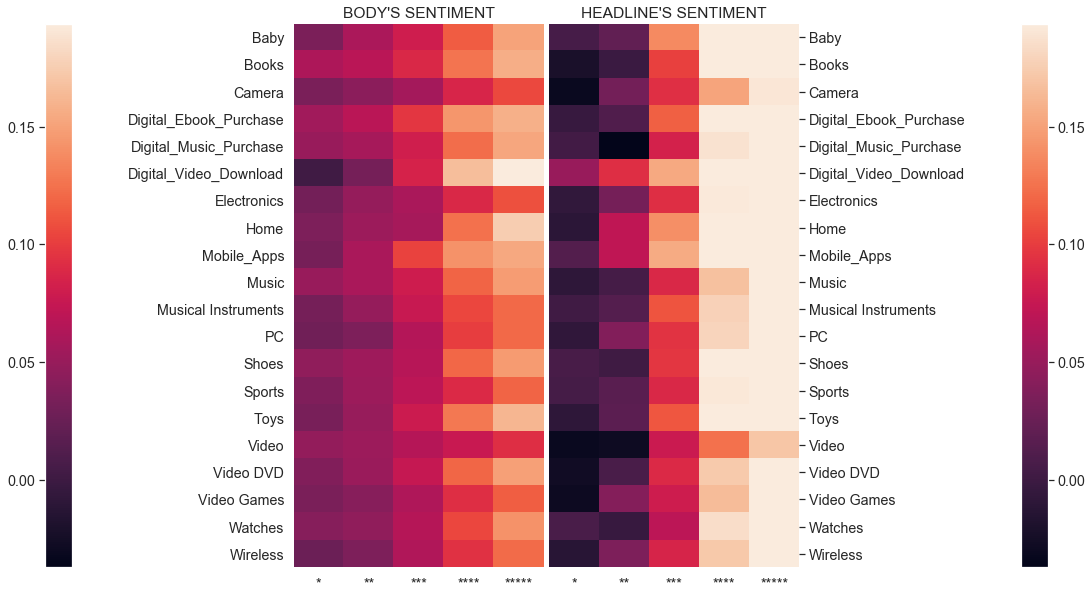

In [166]:
fig, (ax,ax2) = plt.subplots(ncols=2)
fig.subplots_adjust(wspace=+0.01)
sns.heatmap(matrix, 
            xticklabels=['*'*i for i in range(1,6)], 
            yticklabels=categories,
            robust =True, 
            ax = ax,
            cbar=False,
            vmin= min_mean,
            vmax=max_mean)
fig.colorbar(ax.collections[0], ax=ax,location="left", use_gridspec=False, pad=0.4)
sns.heatmap(matrix_head, 
            xticklabels=['*'*i for i in range(1,6)], 
            yticklabels=categories,
            robust =True, 
            ax = ax2,
            cbar=False,
            vmin= min_mean,
            vmax=max_mean)
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.4)
ax.set_title("BODY'S SENTIMENT")
ax2.set_title("HEADLINE'S SENTIMENT")
ax2.yaxis.tick_right()
ax2.tick_params(rotation=0)
plt.show()

### Best Categories

In [167]:
aggregation_head.head(5)

product_category  star_rating      mean       std  count
0             Baby            1  0.005701  0.248128    128
1             Baby            2  0.020637  0.223431    127
2             Baby            3  0.137115  0.196609    231
3             Baby            4  0.234453  0.220338    557
4             Baby            5  0.287943  0.214383   3161

In [168]:
order_cat = df_rev[['product_category','sentiment_headline']].groupby(['product_category']).mean().sort_values("sentiment_headline").index

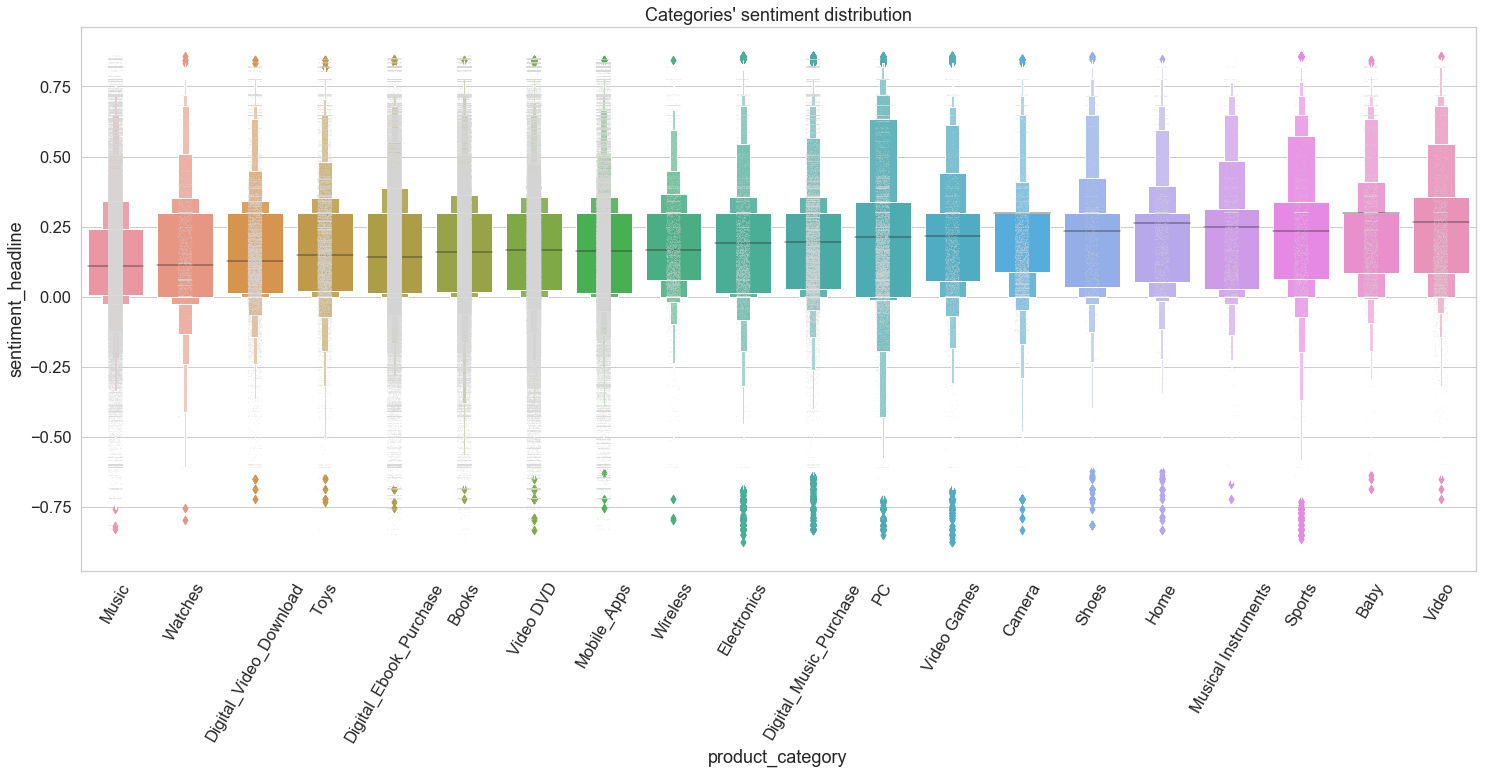

In [169]:
sns.set(font_scale=1.5,style="whitegrid",rc={'figure.figsize':(25,10)})
ax = sns.boxenplot(x="product_category", 
                 y="sentiment_headline",
                 data=df_rev,
                 order=order_cat
               )
ax = sns.stripplot(x="product_category", y="sentiment_headline",data=df_rev,size=0.5, jitter=True, color="#d9d9d9")
plt.xticks(rotation=60)
plt.title("Categories' sentiment distribution")
plt.show()

### Best/Wors Products

In [170]:
TOP = 5

#### Headline

In [171]:
index_best = df_rev.groupby(['product_id']).mean().nlargest(TOP,"sentiment_headline").index
index_worst = df_rev.groupby(['product_id']).mean().nsmallest(TOP,"sentiment_headline").index

In [172]:
df_rev.loc[df_rev.product_id.isin(index_best),("product_title","product_category","star_rating","review_body","review_headline","sentiment_headline")].sort_values(["product_title","sentiment_headline"])

product_title  \
review_id                                                      
58230                                Highway to hell [VINYL]   
163640                             Live In Gdansk (2cd+2dvd)   
1112204                          Peter: A Darkened Fairytale   
163984     Star Trek: Nemesis [DVD] [2003] [Region 1] [US...   
1319810                        The Who Sell Out (Remastered)   

                 product_category  star_rating  \
review_id                                        
58230                       Music            5   
163640                      Music            4   
1112204                     Books            5   
163984                  Video DVD            5   
1319810    Digital_Music_Purchase            5   

                                                 review_body  \
review_id                                                      
58230      [it, was, a, picture, disc, as, shown, but, th...   
163640                               [fats, shopping, happy]   
1112204    [loved, this, fairytale, for, grown, ups, as, ...   
163984                         [happy, with, this, purchase]   
1319810    [took, me, back, to, when, i, first, heard, i,...   

             review_headline  sentiment_headline  
review_id                                         
58230          [uber, happy]             0.84599  
163640               [happy]             0.84599  
1112204            [magical]             0.84836  
163984               [happy]             0.84599  
1319810    [happy, memories]             0.84599

In [173]:
df_rev.loc[df_rev.product_id.isin(index_worst),("product_title","product_category","star_rating","review_body","review_headline","sentiment_headline")].sort_values(["product_title","sentiment_headline"])

product_title product_category  \
review_id                                                                       
1476560                                            Cat's Eye            Books   
274053     Cultural Criminology: Theories of Crime (The L...            Books   
1547799                                                 Mort            Books   
1356309                                      On Chesil Beach            Books   
1684604                          The Exorcist [DVD] [Import]        Video DVD   

           star_rating                                        review_body  \
review_id                                                                   
1476560              4  [if, i, were, to, see, cordelia, again, what, ...   
274053               5  [videoid, you, tell, me, or, read, this, book,...   
1547799              5  [mort, by, terry, pratchett, is, the, fourth, ...   
1356309              5  [very, very, sad, really, because, people, did...   
1684604              5  [man, fragt, sich, was, warner, sich, dabei, d...   

                    review_headline  sentiment_headline  
review_id                                                
1476560                       [sad]            -0.75714  
274053        [what, causes, crime]            -0.78897  
1547799        [introducing, death]            -0.82876  
1356309                       [sad]            -0.75714  
1684604    [besser, die, bestellen]            -0.82652

#### Body

In [174]:
index_best = df_rev.groupby(['product_id']).mean().nlargest(TOP,"sentiment_body").index
index_worst = df_rev.groupby(['product_id']).mean().nsmallest(TOP,"sentiment_body").index

In [175]:
df_rev.loc[df_rev.product_id.isin(index_best),("product_title","product_category","star_rating","review_body","review_headline","sentiment_body")].sort_values(["product_title","sentiment_body"])

product_title product_category  \
review_id                                                                       
74755      Dirty Dancing [DVD] [1987] [Region 1] [US Impo...        Video DVD   
13214                                      Scars On Broadway            Music   
1049129                                     Slowhand [VINYL]            Music   
671140                          X-Men Triple Feature Dvd Set        Video DVD   
620180       harold e maude (blu-ray) blu_ray Italian Import        Video DVD   

           star_rating     review_body review_headline  sentiment_body  
review_id                                                               
74755                5     [fantastic]   [five, stars]         0.81923  
13214                5         [happy]   [five, stars]         0.84599  
1049129              5  [happy, happy]   [five, stars]         0.84599  
671140               5         [happy]   [five, stars]         0.84599  
620180               5         [happy]   [five, stars]         0.84599

In [176]:
df_rev.loc[df_rev.product_id.isin(index_worst),("product_title","product_category","star_rating","review_body","review_headline","sentiment_body")].sort_values(["product_title","sentiment_body"])

product_title        product_category  star_rating  \
review_id                                                           
620040             Babymetal  Digital_Music_Purchase            5   
1169674                Honey  Digital_Video_Download            1   
1268641    Napoleon Dynamite  Digital_Video_Download            1   
1617487      The Conspirator  Digital_Video_Download            1   
68458              Zoolander  Digital_Video_Download            1   
803745             Zoolander  Digital_Video_Download            1   

                       review_body            review_headline  sentiment_body  
review_id                                                                      
620040              [wicked, xxxx]              [five, stars]       -0.573870  
1169674                 [terrible]                [one, star]       -0.720640  
1268641                    [awful]                [one, star]       -0.685400  
1617487                      [bad]                [one, star]       -0.427180  
68458                     [stupid]  [not, worth, paying, for]       -0.573090  
803745     [excruciatingly, awful]                [one, star]       -0.382685

## Best/Worst People

In [177]:
TOP = 3

In [178]:
index_best = df_rev.groupby(['customer_id']).mean().nlargest(TOP,"sentiment_headline").index
index_worst = df_rev.groupby(['customer_id']).mean().nsmallest(TOP,"sentiment_headline").index

In [179]:
df_rev.loc[df_rev.customer_id.isin(index_best),("product_title","product_category","star_rating","review_headline","sentiment_headline")].sort_values("sentiment_headline")

product_title        product_category  \
review_id                                                                  
183653     The Unlikely Pilgrimage Of Harold Fry  Digital_Ebook_Purchase   
375968                              Harvey [DVD]               Video DVD   
390237       Simon and Garfunkel's Greatest Hits                   Music   

           star_rating  review_headline  sentiment_headline  
review_id                                                    
183653               5            [joy]             0.85897  
375968               5  [joy, of, joys]             0.85897  
390237               5            [joy]             0.85897

In [180]:
df_rev.loc[df_rev.customer_id.isin(index_worst),("product_title","product_category","star_rating","review_headline","sentiment_headline")].sort_values("sentiment_headline")

product_title product_category  \
review_id                                                                       
510181     Sophie's World: A Novel About the History of P...            Books   
1050723    The Fast Diet: Lose Weight, Stay Healthy, Live...            Books   
1235135               Pride and Prejudice (Penguin Classics)            Books   

           star_rating            review_headline  sentiment_headline  
review_id                                                              
510181               1  [torture, for, teenagers]            -0.87315  
1050723              2                  [torture]            -0.87315  
1235135              2                  [torture]            -0.87315

#### Body

In [181]:
index_best = df_rev.groupby(['customer_id']).mean().nlargest(TOP,"sentiment_body").index
index_worst = df_rev.groupby(['customer_id']).mean().nsmallest(TOP,"sentiment_body").index

In [182]:
df_rev.loc[df_rev.customer_id.isin(index_best),("customer_id","product_title","product_category","star_rating","review_body","sentiment_body")].sort_values(["customer_id","sentiment_body"])

customer_id                         product_title  \
review_id                                                     
377108       20672971  Með suð í eyrum við spilum endalaust   
1058372      35557576      Alice in Wonderland (Blu-ray 3D)   
1112266      36737819                                Frozen   

                 product_category  star_rating review_body  sentiment_body  
review_id                                                                   
377108                      Music            4   [magical]         0.84836  
1058372                 Video DVD            5   [magical]         0.84836  
1112266    Digital_Video_Download            5   [magical]         0.84836

In [183]:
df_rev.loc[df_rev.customer_id.isin(index_worst),("customer_id","product_title","product_category","star_rating","review_body","sentiment_body")].sort_values(["customer_id","sentiment_body"])

customer_id                                      product_title  \
review_id                                                                  
282700       18351166  Jack The Giant Slayer [Blu-ray] [2013] [Region...   
289180       18547162  A Dance With Dragons: Part 1 Dreams and Dust (...   
1352117      42951641  Fifty Shades Darker: Book Two of the Fifty Sha...   

          product_category  star_rating                 review_body  \
review_id                                                             
282700           Video DVD            5   [frightenedme, to, death]   
289180               Books            5          [dumbledore, dies]   
1352117              Books            3  [prfer, murder, mysteries]   

           sentiment_body  
review_id                  
282700           -0.82876  
289180           -0.82652  
1352117          -0.84831

## Happy periods

### Days

#### Best generally

In [184]:
import calendar

In [185]:
def changeName(number,isMonth):
    if(isMonth):
        return calendar.month_name[number]
    else:
        return calendar.day_name[number]

In [186]:
results = df_rev.groupby([df_rev.review_date.dt.dayofweek]).mean().reset_index()
results.review_date = results.review_date.apply(func=changeName,args=([False]))
results["mean(body,head)"] = (results.sentiment_body+results.sentiment_headline)/2
results.sort_values(["mean(body,head)"],ascending=False).reset_index().drop(["index"], axis=1)

review_date  star_rating  sentiment_body  sentiment_headline  \
0   Wednesday     4.390303        0.137233            0.204059   
1      Friday     4.395186        0.135481            0.203101   
2    Thursday     4.393401        0.135395            0.202701   
3    Saturday     4.383570        0.134610            0.203239   
4      Sunday     4.381569        0.134013            0.203601   
5      Monday     4.382661        0.133823            0.201963   
6     Tuesday     4.371085        0.132334            0.200300   

   mean(body,head)  
0         0.170646  
1         0.169291  
2         0.169048  
3         0.168924  
4         0.168807  
5         0.167893  
6         0.166317

#### Divided by year and category

In [187]:
FromYear = 2011

In [188]:
period = df_rev[df_rev.review_date.dt.year>=FromYear]
period["day"] = period["review_date"]
period = period.groupby([period.product_category,period.review_date.dt.year,period.day.dt.dayofweek]).mean().reset_index()

In [189]:
period.head(5)

product_category  review_date  day  star_rating  sentiment_body  \
0             Baby         2011    0     4.446429        0.105050   
1             Baby         2011    1     4.473684        0.103819   
2             Baby         2011    2     4.553571        0.102727   
3             Baby         2011    3     4.411765        0.110734   
4             Baby         2011    4     4.491228        0.096902   

   sentiment_headline  
0            0.260006  
1            0.215062  
2            0.258712  
3            0.203729  
4            0.243486

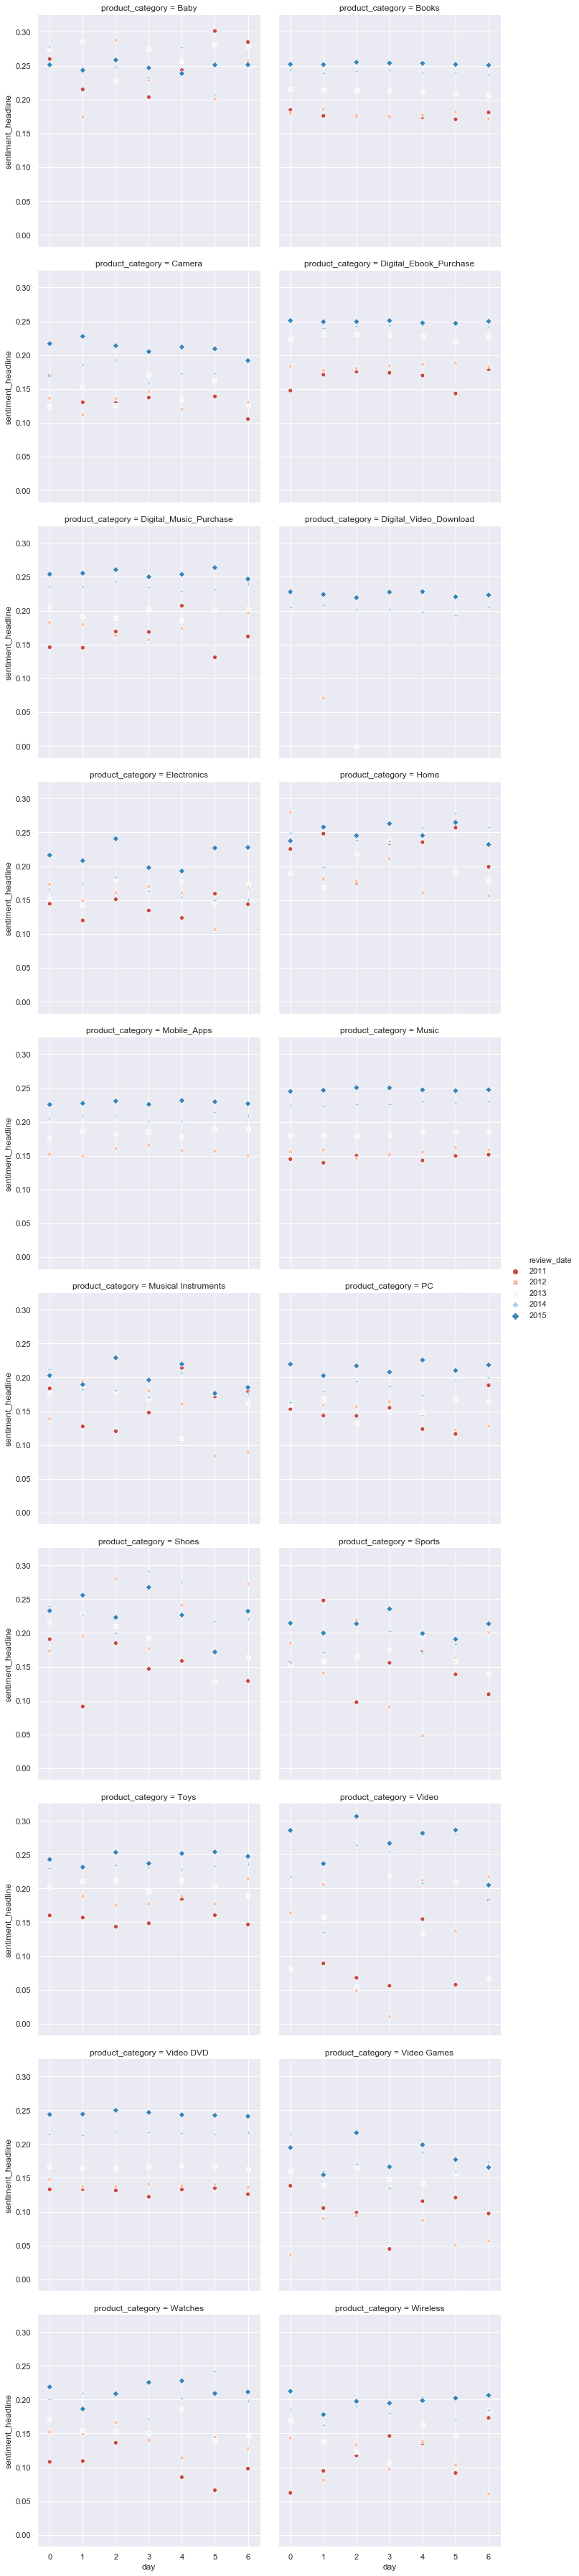

In [190]:
sns.set(font_scale=1,style="darkgrid")
sns.relplot(x="day", 
             y="sentiment_headline",
             col="product_category",
            hue="review_date",
            style="review_date",
            col_wrap=2,
            palette= sns.color_palette("RdBu",n_colors=5),
             data=period,
           legend = "full")
plt.show()

## Month

#### Best generally

In [191]:
results = df_rev.groupby([df_rev.review_date.dt.month]).mean().reset_index()
results.review_date = results.review_date.apply(func=changeName,args=([True]))
results["mean(body,head)"] = (results.sentiment_body+results.sentiment_headline)/2
results.sort_values(["mean(body,head)"],ascending=False).reset_index().drop(["index"], axis=1)

review_date  star_rating  sentiment_body  sentiment_headline  \
0       August     4.378174        0.146255            0.211569   
1         July     4.374573        0.143586            0.208575   
2     December     4.410284        0.136404            0.204659   
3      January     4.415782        0.134703            0.206061   
4     February     4.410968        0.134112            0.206561   
5        March     4.398094        0.131719            0.203977   
6      October     4.365999        0.134946            0.196513   
7        April     4.394240        0.129628            0.201816   
8          May     4.372081        0.129047            0.199398   
9    September     4.356079        0.132725            0.194787   
10    November     4.365627        0.130578            0.194471   
11        June     4.354656        0.128610            0.196095   

    mean(body,head)  
0          0.178912  
1          0.176080  
2          0.170532  
3          0.170382  
4          0.170337  
5          0.167848  
6          0.165730  
7          0.165722  
8          0.164222  
9          0.163756  
10         0.162525  
11         0.162353

#### Divided by year and category

In [192]:
FromYear = 2011

In [193]:
period = df_rev[df_rev.review_date.dt.year>=2012]
period["month"] = period["review_date"]
period = period.groupby([period.product_category,period.review_date.dt.year,period.month.dt.month]).mean().reset_index()

In [194]:
period.head(5)

product_category  review_date  month  star_rating  sentiment_body  \
0             Baby         2012      1     4.615385        0.126988   
1             Baby         2012      2     4.514286        0.093684   
2             Baby         2012      3     4.642857        0.099625   
3             Baby         2012      4     4.805556        0.095864   
4             Baby         2012      5     4.484848        0.120489   

   sentiment_headline  
0            0.236783  
1            0.257625  
2            0.351512  
3            0.189190  
4            0.192412

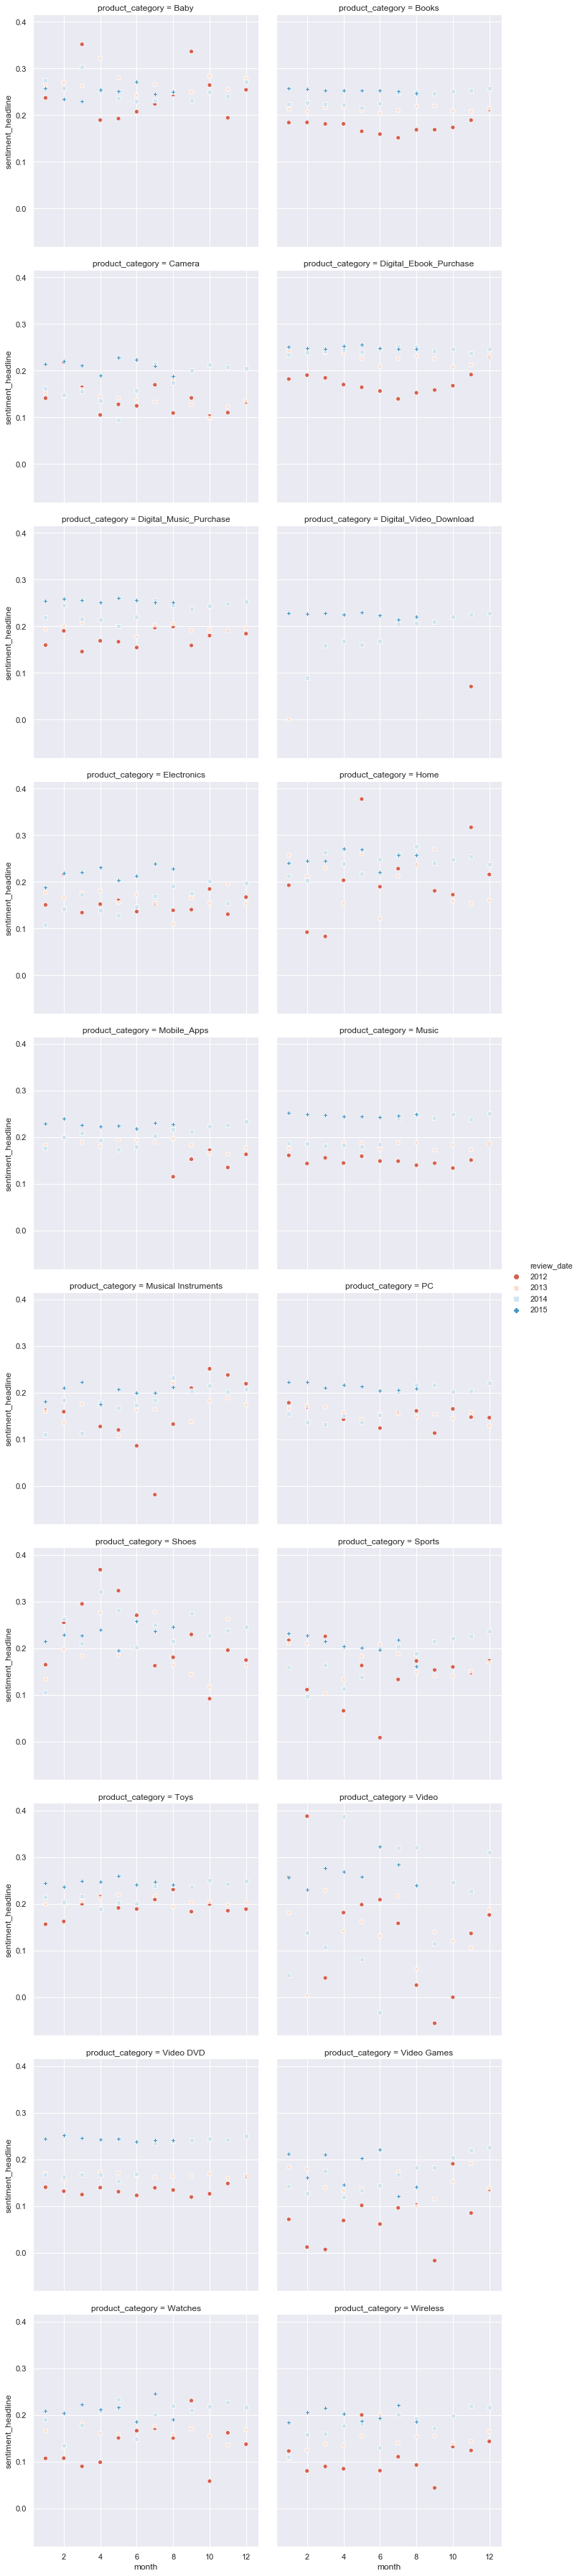

In [195]:
sns.set(font_scale=1,style="darkgrid")
sns.relplot(x="month", 
             y="sentiment_headline",
             col="product_category",
            hue="review_date",
            style="review_date",
            col_wrap=2,
            palette= sns.color_palette("RdBu",n_colors=len(period.review_date.unique())),
             data=period,
           legend = "full")
plt.show()